#### Libraries Import
* Custom modules used:
    * custom_variable_transformation: module with class to handle media transformations
    * custom_seasonality_analysis: module with class to handle seasonality
    * custom_transformation_functions: module with common transformation functions
    * eda_visualization: reusing eda class for plotting

In [1]:
# Dataframe and array manipulation
import pandas as pd
import numpy as np
import os

# Custom Libraries for saving excel and transformation of variables
import os
import sys
module_path = os.path.abspath(os.path.join('../../src/utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('../eda'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_variable_transformation import VariableTransformation, final_variable_selection, create_media_hierarchy
from custom_transformation_functions import find_best_var_transformation, create_lag_lead, find_best_var_transformation_media
from custom_seasonality_analysis import VariableSeasonality
from save_excel import SaveExcelTemplated
from eda_visualization import EDA_visualization

import warnings
warnings.filterwarnings('ignore')

from openpyxl import load_workbook

#### Defining modelling and validation period
* Only modelling period would be used for ranking all the transformation rankings
* Only modelling period would be used for ranking of dummy variables
* Validation data would be prepared along with the modelling data (e.g. preparation of media transformations)

In [2]:
# keep validation_start = None and validation_end = None for no validation period
modelling_start = '2019-01-01' 
modelling_end = '2020-12-31'

validation_start = '2021-01-01' 
validiation_end = '2021-04-30'

#### Defining apply_adstock
* When apply_adstock = False, only lag and halflife will be applied to variable transformation, no build up.

In [ ]:
apply_adstock = True

#### Definining the decimal places of each metric

In [3]:
# Defining the decimal places for each diagnostic metric
decimal_3_col_names = ['MAPE', 'R-Squared', 'R-Squared Adjusted', 'SCurve-Scale', 'SCurve-Inflection']  # 3 decimal places 
decimal_5_col_names = ['Correlation', 'AIC', 'BIC', 'Coefficient']  # 5 decimal places
scientific_col_names = ['P-Val']  # Scientific format

#### Define target variables and create the required folders

In [4]:
# specify the media to be used i.e. Impressions, clicks, viewable impressions or spends
media_dictionary = {'IMP' : 'Impression',
                    'SPEND' : 'Spend',
                    'VIEW_IMP' : 'Viewable Impression',
                    'CLK' : 'Click'}

In [5]:
# declare the target variables
units_target_var = 'O_UNIT'
cust_target_var = 'O_NEW_CUSTOMER'

# declare the folder name for each target variable
target_folder_dict = {units_target_var : 'sales_unit',
                      cust_target_var : 'new_customer'}

# final file that would be input to the modelling
modelling_stack_file = "02_modelling_stack_data_seasonality.csv"

# folders creation
base_folder = "../../data/output_data/modelling_output/" 

# folder creation for target variables (folder would be only created if not present already)
for key, value in target_folder_dict.items():
    try:
        os.mkdir(base_folder + value)
    except:
        print(base_folder + value + " folder already exists")
        

units_path = base_folder + target_folder_dict[units_target_var] + "/"
cust_path = base_folder + target_folder_dict[cust_target_var] + "/"

../../data/output_data/modelling_output/sales_unit folder already exists
../../data/output_data/modelling_output/new_customer folder already exists


#### Loading the dataframe

In [6]:
# post development, this cell would be replaced with option to browse the file
input_file_path = "../../data/input_data/modeling_stack.csv" 
data_dict_path = "../../data/input_data/WMG WAMM Project Data Dictionary_v12.xlsx"

In [7]:
df = pd.read_csv(input_file_path)
df['index'] = pd.to_datetime(df['index']) # Formatting the date
df.set_index("index", inplace = True, drop= False) 

data_dict = pd.read_excel(data_dict_path)

#### Creating additional media variables
These variables would not be considered in the automated flow
- M_ON_DIS_AT_HPLO_SEA_IMP  [Behavioral + Homepage+ Seasonal]
- M_ON_DIS_AT_HPLO_IMP  [Behavioral + Homepage]
- M_ON_DIS_CT_HPLO_IMP [Contextual + Homepage]
- M_ON_DIS_CT_SEA_IMP  [Contextual + Seasonal]
- M_ON_DIS_SEA_HPLO_IMP [Seasonal + Homepage]
- M_ON_DIS_AT_CT_IMP  [Behavioral + Contextual]

In [8]:
# upload the media hierarchy (this media hierarchy is the default one created on the IMP media)
media_hierarchy = pd.read_csv("../../data/input_data/media_hierarchy.csv")

In [9]:
new_var_dict = {'M_ON_DIS_AT_CT_IMP' : ['M_ON_DIS_AT_IMP', 'M_ON_DIS_CT_IMP'],
               'M_ON_DIS_AT_ROS_IMP' : ['M_ON_DIS_AT_IMP', 'M_ON_DIS_ROS_IMP'],
                'M_ON_DIS_CT_ROS_IMP' : ['M_ON_DIS_CT_IMP', 'M_ON_DIS_ROS_IMP'],
               'M_ON_DIS_KW_ROS_IMP' : ['M_ON_DIS_KW_IMP', 'M_ON_DIS_ROS_IMP'],
               'M_ON_DIS_ROS_HPLO_IMP' : ['M_ON_DIS_SEA_IMP', 'M_ON_DIS_HPLO_IMP']}

In [10]:
final_var_results = create_media_hierarchy(new_var_dict= new_var_dict, df= df, media_dictionary= media_dictionary,
                                           data_dict= data_dict, media_hierarchy= media_hierarchy,
                                           var_type= 'Media Driver', media_hierarchy_level= 5, product_type= 'Onsite Display')

In [11]:
final_var_results.keys()

dict_keys(['Created Variables', 'Dataframe', 'Updated Media Hierarchy', 'Updated Data Dictionary'])

In [12]:
df = final_var_results['Dataframe']
media_hierarchy = final_var_results['Updated Media Hierarchy']
added_media_vars = final_var_results['Created Variables']
data_dict = final_var_results['Updated Data Dictionary']

In [13]:
media_hierarchy.to_csv("../../data/input_data/media_hierarchy_IMP.csv", index= False)

In [14]:
# replicating media hierarchy of impressions to other media
for key in media_dictionary.keys():
    if key == 'IMP':
        continue
    media_hierarchy_media = media_hierarchy.copy()
    for col in media_hierarchy_media:
        media_hierarchy_media[col] = media_hierarchy_media[col].str.replace('IMP', key)
        
    media_hierarchy_media.to_csv("../../data/input_data/media_hierarchy_{}.csv".format(key), index= False)

#### Creation of new customer online variable (can be skipped if already created in EDA process)

In [15]:
# # New customer online = email + omni
#df['O_NEW_CUSTOMER_ONLINE'] = df['O_NEW_CUSTOMER_EMAIL'] + df['O_NEW_CUSTOMER_OMNI_EMAIL']

# # Online Price
#df['PRICE_ONLINE'] = df['O_SALE_ONLINE']/df['O_UNIT_ONLINE']

In [16]:
df.columns

Index(['index', 'O_SALE', 'O_UNIT', 'O_SALE_TRACEABLE', 'O_SALE_CASH',
       'O_UNIT_TRACEABLE', 'O_UNIT_CASH', 'O_SALE_STORE', 'O_SALE_OG',
       'O_SALE_DOTCOM',
       ...
       'M_ON_DIS_CT_ROS_VIEW_IMP', 'M_ON_DIS_CT_ROS_CLK',
       'M_ON_DIS_KW_ROS_IMP', 'M_ON_DIS_KW_ROS_SPEND',
       'M_ON_DIS_KW_ROS_VIEW_IMP', 'M_ON_DIS_KW_ROS_CLK',
       'M_ON_DIS_ROS_HPLO_IMP', 'M_ON_DIS_ROS_HPLO_SPEND',
       'M_ON_DIS_ROS_HPLO_VIEW_IMP', 'M_ON_DIS_ROS_HPLO_CLK'],
      dtype='object', length=710)

In [17]:
book = load_workbook(data_dict_path)
writer = pd.ExcelWriter(data_dict_path.replace('5', '6'), engine='openpyxl') 

writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

data_dict.to_excel(writer, sheet_name= "Data Dictionary", index= False)

writer.save()

#### Preparation of modelling and validation datasets

In [18]:
df_model = df[(df.index >= modelling_start) & (df.index <= modelling_end)]

if validation_start:
    df_valid = df[(df.index >= validation_start) & (df.index <= validiation_end)]
else:
    df_valid = pd.DataFrame(columns= df_model.columns)

In [19]:
df_model['index'].dt.year.value_counts()

2020    366
2019    365
Name: index, dtype: int64

In [20]:
df_model.shape, df_valid.shape

((731, 710), (31, 710))

In [21]:
# Original dataframe would not be used in the later stages of the code
del df

In [22]:
if df_valid.shape[0] != 0:
    df_model_valid = pd.concat([df_model, df_valid], axis= 0)
else:
    df_model_valid = df_model.copy()

In [23]:
df_model_valid.shape

(762, 710)

In [24]:
try:
    df_model_valid.to_csv("../../data/processed_input_data/01_modelling_stack_data_dummy_vars.csv",
             index= False)
except:
    new_path = os.path.abspath("../../data/processed_input_data/01_modelling_stack_data_dummy_vars.csv")
    new_path = "\\\\?\\" + new_path
    df_model_valid.to_csv(new_path, index= False)

#### Trend & Seasonality 

#### New Customer Count

In [25]:
seas_obj_cust = VariableSeasonality(df_model_valid, cust_target_var,
                                    file_path = cust_path + 'seasonality_new_customer.xlsx',
                                    modelling_start= modelling_start, modelling_end= modelling_end,
                                    validation_start= validation_start, validiation_end= validiation_end)

Augmented Dickey-Fuller
ADF  Statistic           -2.979707
P-Value                   0.036833
#Lags Used               14.000000
#Observations           747.000000
critical value (1%)      -3.439134
critical value (5%)      -2.865417
critical value (10%)     -2.568834
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Since Data is Stationary, we will be using SARIMAX and enforce stationarity


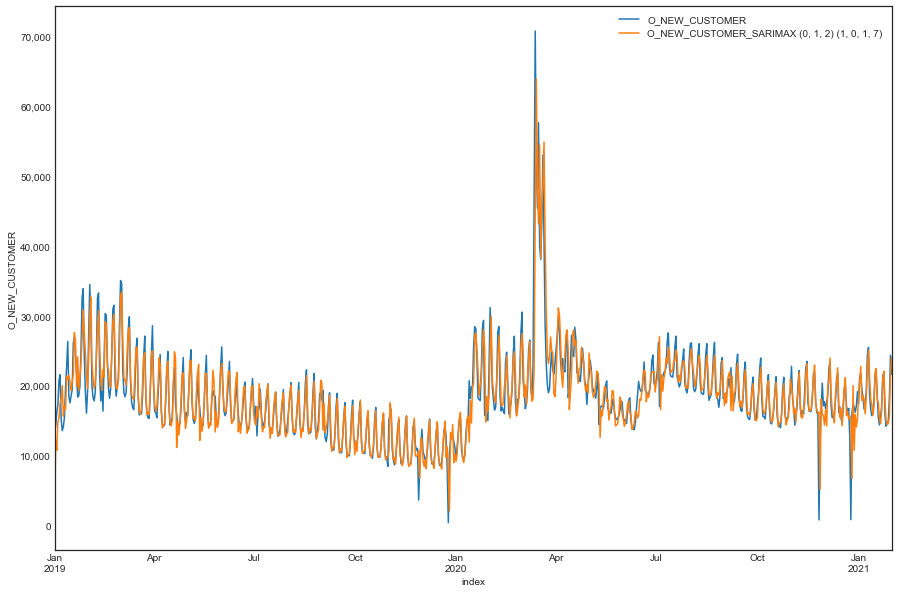

In [26]:
# custom_order and custom_seasonal_order would overwrite the order from autom arima
# these are optional parameters
seas_obj_cust.arma_arima_func(start_p= 1, start_q= 1)

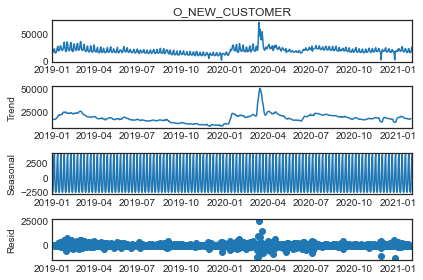

In [27]:
# additional_period_start_date is optional parameter. for this period, ETS terms would be created separately
seas_obj_cust.creating_var_func()

In [28]:
# function to create the rank for all the variables
seas_obj_cust.ranking_func(decimal_col_names= decimal_3_col_names, 
                           scientific_col_names= scientific_col_names,
                           decimal_5_col_names= decimal_5_col_names)

Variable Transformation       MAPE          P-Val  \
0  O_NEW_CUSTOMER_SARIMAX (0, 1, 2) (1, 0, 1, 7)  16.805377  1.220877e-254   
1                           O_NEW_CUSTOMER_TREND  23.281600  4.616391e-174   
2                        O_NEW_CUSTOMER_RESIDUAL  30.499488   1.758473e-33   
3                     O_NEW_CUSTOMER_SEASONALITY  33.282084   1.577118e-32   

   Correlation           AIC  R-Squared  R-Squared Adjusted           BIC  \
0     0.892759  13691.936312  79.701946           79.674102  13701.125139   
1     0.813877  14063.843224  66.239563           66.193253  14073.032051   
2     0.425355  14711.727522  18.092691           17.980335  14720.916349   
3     0.419539  14716.099836  17.601312           17.488282  14725.288663   

   Rank : MAPE  Rank : P-Val  Rank : Correlation  Rank : AIC  \
0          1.0           1.0                 1.0         1.0   
1          2.0           2.0                 2.0         2.0   
2          3.0           3.0                 3.0         3.0   
3          4.0           4.0                 4.0         4.0   

   Rank : R-Squared  Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  \
0               1.0                        1.0         1.0        7.0   
1               2.0                        2.0         2.0       14.0   
2               3.0                        3.0         3.0       21.0   
3               4.0                        4.0         4.0       28.0   

   Final Rank  
0         1.0  
1         2.0  
2         3.0  
3         4.0

In [29]:
# Addition of the seasonality variables to the actual dataset
df_model_valid = seas_obj_cust.df

#### Volume Sales Units

In [30]:
seas_obj_units = VariableSeasonality(df_model_valid, units_target_var, 
                                     file_path = units_path + 'seasonality_sales_units.xlsx',
                                     modelling_start= modelling_start, modelling_end= modelling_end,
                                     validation_start= validation_start, validiation_end= validiation_end)

Augmented Dickey-Fuller
ADF  Statistic           -3.823428
P-Value                   0.002677
#Lags Used               20.000000
#Observations           741.000000
critical value (1%)      -3.439206
critical value (5%)      -2.865448
critical value (10%)     -2.568851
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Since Data is Stationary, we will be using SARIMAX and enforce stationarity


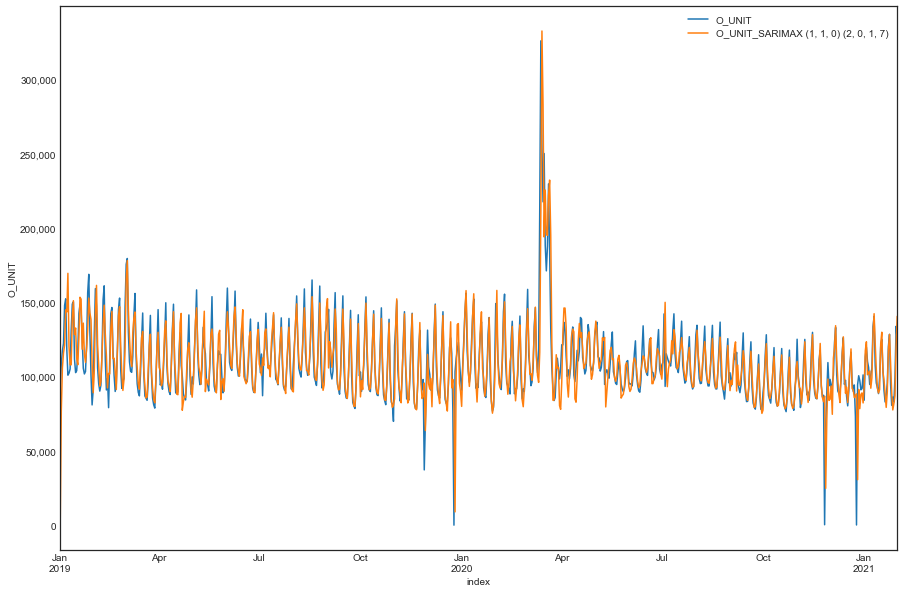

In [31]:
seas_obj_units.arma_arima_func(start_p= 1, start_q= 1)

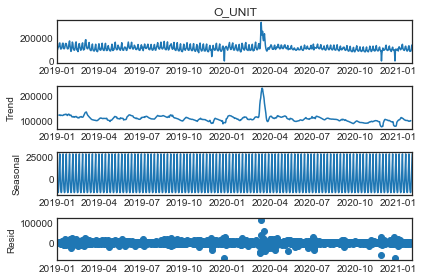

In [32]:
seas_obj_units.creating_var_func()

In [33]:
seas_obj_units.ranking_func(decimal_col_names= decimal_3_col_names, 
                                       scientific_col_names= scientific_col_names,
                                       decimal_5_col_names= decimal_5_col_names)

Variable Transformation        MAPE          P-Val  \
0  O_UNIT_SARIMAX (1, 1, 0) (2, 0, 1, 7)  548.841356  6.487708e-179   
1                     O_UNIT_SEASONALITY  614.716021   3.638472e-82   
2                           O_UNIT_TREND  599.275187   6.629437e-67   
3                        O_UNIT_RESIDUAL  177.682794   1.312105e-46   

   Correlation           AIC  R-Squared  R-Squared Adjusted           BIC  \
0     0.820110  16083.734251  67.258005           67.213091  16092.923078   
1     0.630185  16529.975927  39.713256           39.630558  16539.164754   
2     0.579889  16600.280625  33.627136           33.536089  16609.469452   
3     0.495778  16693.694531  24.579622           24.476165  16702.883358   

   Rank : MAPE  Rank : P-Val  Rank : Correlation  Rank : AIC  \
0          2.0           1.0                 1.0         1.0   
1          4.0           2.0                 2.0         2.0   
2          3.0           3.0                 3.0         3.0   
3          1.0           4.0                 4.0         4.0   

   Rank : R-Squared  Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  \
0               1.0                        1.0         1.0        8.0   
1               2.0                        2.0         2.0       16.0   
2               3.0                        3.0         3.0       21.0   
3               4.0                        4.0         4.0       25.0   

   Final Rank  
0         1.0  
1         2.0  
2         3.0  
3         4.0

In [34]:
df_model_valid = seas_obj_units.df

#### Analysis of Holiday Variables
Regression of holiday flags against Volume Sales Units and New Customer Count

In [35]:
#get the seasonality variable
seas_ar_units_cols = [col for col in df_model.columns if (col.startswith(units_target_var + '_SAR')) & ('LOG' not in col)]+['D_NATIONAL_WEATHER']
seas_ar_units_cols += ['PRICE','BRAND_DISTRIBUTION_TDP','INVENTORY_OOS_RATE_STORE','Crest_O_PRICE','Colgate_O_PRICE','O_CAT_ORAL CARE_O_UNIT','Colgate_MEDIA_SPEND','Crest_MEDIA_SPEND']
seas_ar_cust_cols = [col for col in df_model.columns if (col.startswith(cust_target_var + '_SAR')) & ('LOG' not in col)]+['D_NATIONAL_WEATHER']
seas_ar_cust_cols += ['PRICE','INVENTORY_OOS_RATE_DOTCOM','Crest_O_PRICE','Colgate_O_PRICE','O_CAT_ORAL CARE_O_UNIT','Colgate_MEDIA_SPEND','Crest_MEDIA_SPEND']

In [36]:
holiday_flags = [col for col in df_model if col.startswith('D_HOL')]

In [37]:
dummy_vars_df_model_dict = {}  # Dictionary of all the ranking dataframes

###### Documentation of function: find_best_var_transformation

The function can be used to rank the variables by running univariate regression (or multivariate regression by adding a seasonality term).

Params:
* target_var_series: Target series
* var_transformations: Dataframe of all the ranking variables
* seasonality_var_series(optional): Add seasonality series to independent variables
* intercept(boolean): to add intercept term in linear equation
* mape, pval, corr, aic, r_sq, r_sq_adj, bic: Toggles to turn on/off the metrics in final ranking. By default, all are set to True. Setting to False would exclude the metric from final ranking. Ranks for all the metrics would be still shown in the output (but would not be used in the final ranking).


In [38]:
df_model[holiday_flags].copy()

D_HOL_SUPER_BOWL  D_HOL_VALENTINE_DAY  D_HOL_ST_PATRICK_DAY  \
index                                                                     
2019-01-01                 0                    0                     0   
2019-01-02                 0                    0                     0   
2019-01-03                 0                    0                     0   
2019-01-04                 0                    0                     0   
2019-01-05                 0                    0                     0   
...                      ...                  ...                   ...   
2020-12-27                 0                    0                     0   
2020-12-28                 0                    0                     0   
2020-12-29                 0                    0                     0   
2020-12-30                 0                    0                     0   
2020-12-31                 0                    0                     0   

            D_HOL_EASTER  D_HOL_FATHER_DAY  D_HOL_MONTHER_DAY  \
index                                                           
2019-01-01             0                 0                  0   
2019-01-02             0                 0                  0   
2019-01-03             0                 0                  0   
2019-01-04             0                 0                  0   
2019-01-05             0                 0                  0   
...                  ...               ...                ...   
2020-12-27             0                 0                  0   
2020-12-28             0                 0                  0   
2020-12-29             0                 0                  0   
2020-12-30             0                 0                  0   
2020-12-31             0                 0                  0   

            D_HOL_HALLOWEEN  D_HOL_CHRISTMAS  D_HOL_COLUMBUS_DAY  \
index                                                              
2019-01-01                0                0                   0   
2019-01-02                0                0                   0   
2019-01-03                0                0                   0   
2019-01-04                0                0                   0   
2019-01-05                0                0                   0   
...                     ...              ...                 ...   
2020-12-27                0                0                   0   
2020-12-28                0                0                   0   
2020-12-29                0                0                   0   
2020-12-30                0                0                   0   
2020-12-31                0                0                   0   

            D_HOL_JULY_4TH  D_HOL_LABOR_DAY  D_HOL_MARTIN_LUTHER_KING_JR_DAY  \
index                                                                          
2019-01-01               0                0                                0   
2019-01-02               0                0                                0   
2019-01-03               0                0                                0   
2019-01-04               0                0                                0   
2019-01-05               0                0                                0   
...                    ...              ...                              ...   
2020-12-27               0                0                                0   
2020-12-28               0                0                                0   
2020-12-29               0                0                                0   
2020-12-30               0                0                                0   
2020-12-31               0                0                                0   

            D_HOL_MEMORIAL_DAY  D_HOL_NEW_YEARS_DAY  D_HOL_PRESIDENTS_DAY  \
index                                                                       
2019-01-01                   0                    1                     0   
2019-01-02                   0   

In [39]:
# Regressing on Volume Sales
# holiday_sales_rank = find_best_var_transformation(df_model[units_target_var],
#                                                  df_model[holiday_flags],seasonality_var_series=df_model[seas_ar_units_cols], intercept= True)

# # Example to show how the toggles can be applied to different metrics
holiday_sales_rank = find_best_var_transformation(df_model[units_target_var].copy(), df_model[holiday_flags].copy(), 
#                                                 seasonality_var_series=df_model[seas_ar_units_cols].copy(), 
                                                  intercept= True,
                                                   corr= False)

dummy_vars_df_model_dict['Sales Holidays'] = holiday_sales_rank
holiday_sales_rank.head(10)

Variable Transformation        MAPE         P-Val  Correlation  \
0                  D_HOL_CHRISTMAS   67.161057  5.684493e-10    -0.226673   
1               D_HOL_THANKSGIVING  667.198597  3.064262e-07    -0.187981   
2             D_HOL_ST_PATRICK_DAY  707.138921  1.612551e-03     0.116443   
3                 D_HOL_SUPER_BOWL  707.562239  6.563878e-02     0.068125   
4                  D_HOL_LABOR_DAY  707.814149  2.318521e-01     0.044275   
5              D_HOL_VALENTINE_DAY  708.615386  1.497313e-01    -0.053331   
6                  D_HOL_HALLOWEEN  708.631467  1.580947e-01    -0.052260   
7  D_HOL_MARTIN_LUTHER_KING_JR_DAY  708.010225  5.573868e-01     0.021736   
8              D_HOL_NEW_YEARS_DAY  708.485948  3.279667e-01    -0.036231   
9               D_HOL_VETERANS_DAY  708.391401  5.844097e-01    -0.020262   

            AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0  16861.345688   5.138071            5.007945  16870.534515          1.0   
1  16873.605621   3.533682            3.401356  16882.794448          2.0   
2  16889.924799   1.355906            1.220592  16899.113626          3.0   
3  16896.503805   0.464101            0.327564  16905.692632          4.0   
4  16898.469914   0.196028            0.059122  16907.658740          5.0   
5  16897.822175   0.284425            0.147641  16907.011002         16.0   
6  16897.905089   0.273114            0.136314  16907.093915         17.0   
7  16899.558851   0.047243           -0.089866  16908.747678          6.0   
8  16898.944088   0.131267           -0.005727  16908.132915         15.0   
9  16899.604095   0.041057           -0.096061  16908.792922         14.0   

   Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0           1.0                17.0         1.0               1.0   
1           2.0                16.0         2.0               2.0   
2           3.0                 1.0         3.0               3.0   
3           4.0                 2.0         4.0               4.0   
4           7.0                 3.0         7.0               7.0   
5           5.0                15.0         5.0               5.0   
6           6.0                14.0         6.0               6.0   
7           9.0                 4.0         9.0               9.0   
8           8.0                13.0         8.0               8.0   
9          10.0                12.0        10.0              10.0   

   Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                        1.0         1.0        6.0         1.0  
1                        2.0         2.0       12.0         2.0  
2                        3.0         3.0       18.0         3.0  
3                        4.0         4.0       24.0         4.0  
4                        7.0         7.0       40.0         5.0  
5                        5.0         5.0       41.0         6.0  
6                        6.0         6.0       47.0         7.0  
7                        9.0         9.0       51.0         8.0  
8                        8.0         8.0       55.0         9.0  
9                       10.0        10.0       64.0        10.0

In [40]:
# Regressing on New Customers
holiday_customer_rank = find_best_var_transformation(df_model[cust_target_var], 
                                                     df_model[holiday_flags], 
#                                                      seasonality_var_series=df_model[seas_ar_cust_cols], 
                                                     intercept= True,corr= False)
dummy_vars_df_model_dict['Customer Holidays'] = holiday_customer_rank

holiday_customer_rank.head(10)

Variable Transformation       MAPE     P-Val  Correlation  \
0                  D_HOL_CHRISTMAS  28.414896  0.000054    -0.148737   
1               D_HOL_THANKSGIVING  34.787846  0.000243    -0.135310   
2             D_HOL_ST_PATRICK_DAY  37.935496  0.000617     0.126348   
3                 D_HOL_SUPER_BOWL  37.962890  0.033295     0.078738   
4              D_HOL_NEW_YEARS_DAY  38.032305  0.122433    -0.057182   
5                  D_HOL_HALLOWEEN  38.103652  0.296527    -0.038662   
6               D_HOL_VETERANS_DAY  38.094266  0.297891    -0.038553   
7  D_HOL_MARTIN_LUTHER_KING_JR_DAY  38.036490  0.316266     0.037117   
8               D_HOL_COLUMBUS_DAY  38.099459  0.361901    -0.033770   
9             D_HOL_PRESIDENTS_DAY  38.054425  0.389010     0.031907   

            AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0  14841.268582   2.212282            2.078143  14850.457409          1.0   
1  14844.114075   1.830891            1.696229  14853.302902          2.0   
2  14845.858180   1.596389            1.461404  14855.047007          3.0   
3  14853.075842   0.619970            0.483646  14862.264669          4.0   
4  14855.227820   0.326976            0.190250  14864.416647          5.0   
5  14856.528444   0.149476            0.012507  14865.717271         12.0   
6  14856.534599   0.148635            0.011665  14865.723426         10.0   
7  14856.614156   0.137767            0.000782  14865.802982          6.0   
8  14856.787791   0.114044           -0.022974  14865.976618         11.0   
9  14856.877348   0.101806           -0.035229  14866.066175          7.0   

   Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0           1.0                17.0         1.0               1.0   
1           2.0                16.0         2.0               2.0   
2           3.0                 1.0         3.0               3.0   
3           4.0                 2.0         4.0               4.0   
4           5.0                15.0         5.0               5.0   
5           6.0                14.0         6.0               6.0   
6           7.0                13.0         7.0               7.0   
7           8.0                 3.0         8.0               8.0   
8           9.0                12.0         9.0               9.0   
9          10.0                 4.0        10.0              10.0   

   Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                        1.0         1.0        6.0         1.0  
1                        2.0         2.0       12.0         2.0  
2                        3.0         3.0       18.0         3.0  
3                        4.0         4.0       24.0         4.0  
4                        5.0         5.0       30.0         5.0  
5                        6.0         6.0       42.0         6.0  
6                        7.0         7.0       45.0         7.0  
7                        8.0         8.0       46.0         8.0  
8                        9.0         9.0       56.0         9.0  
9                       10.0        10.0       57.0        10.0

#### Mod Reset Variables

In [41]:
mod_reset_vars = [col for col in df_model.columns if col.startswith('D_MOD')]

In [42]:
# # Regressing Sales on Mod variables
mod_sales_rank = find_best_var_transformation(df_model[units_target_var].copy(), 
                                              df_model[mod_reset_vars].copy(), 
#                                               seasonality_var_series=df_model[seas_ar_units_cols].copy(), 
                                              intercept= True,corr=False)
dummy_vars_df_model_dict['Sales Mod'] = mod_sales_rank

mod_sales_rank.head(5)

Variable Transformation        MAPE     P-Val  Correlation  \
0                   D_MOD_BAG_CEREAL  705.090678  0.053548     0.071432   
1                  D_MOD_COLD_CEREAL  705.335409  0.096620     0.061499   
2  D_MOD_COLD_CEREAL_658_STORE_COUNT  707.223436  0.469140     0.026815   
3   D_MOD_COLD_CEREAL_58_STORE_COUNT  707.517757  0.565854     0.021270   
4       D_MOD_BAG_CEREAL_STORE_COUNT  707.642256  0.615106     0.018627   

            AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0  16896.164772   0.510255            0.373780  16905.353599          1.0   
1  16897.134338   0.378208            0.241553  16906.323165          2.0   
2  16899.378481   0.071903           -0.065173  16908.567308          3.0   
3  16899.573481   0.045243           -0.091869  16908.762308          4.0   
4  16899.650607   0.034696           -0.102430  16908.839434          5.0   

   Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0           1.0                 1.0         1.0               1.0   
1           2.0                 2.0         2.0               2.0   
2           3.0                 3.0         3.0               3.0   
3           4.0                 4.0         4.0               4.0   
4           5.0                 5.0         5.0               5.0   

   Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                        1.0         1.0        6.0         1.0  
1                        2.0         2.0       12.0         2.0  
2                        3.0         3.0       18.0         3.0  
3                        4.0         4.0       24.0         4.0  
4                        5.0         5.0       30.0         5.0

In [43]:
# # Regressing New Customer on Mod variables
mod_cust_rank = find_best_var_transformation(df_model[cust_target_var].copy(), 
                                             df_model[mod_reset_vars].copy(),
#                                              seasonality_var_series=df_model[seas_ar_cust_cols].copy(), 
                                             intercept= True,corr=False)
dummy_vars_df_model_dict['Customer Mod'] = mod_cust_rank

mod_cust_rank.head(5)

Variable Transformation       MAPE     P-Val  Correlation  \
0       D_MOD_BAG_CEREAL_STORE_COUNT  38.012411  0.039488    -0.076177   
1                  D_MOD_COLD_CEREAL  37.928952  0.072557     0.066453   
2   D_MOD_COLD_CEREAL_58_STORE_COUNT  38.119640  0.101576    -0.060604   
3                   D_MOD_BAG_CEREAL  37.971778  0.103522     0.060263   
4  D_MOD_COLD_CEREAL_658_STORE_COUNT  38.146806  0.354752    -0.034276   

            AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0  14853.367617   0.580295            0.443917  14862.556444          3.0   
1  14854.386652   0.441604            0.305036  14863.575479          1.0   
2  14854.932115   0.367287            0.230617  14864.120942          4.0   
3  14854.962405   0.363159            0.226483  14864.151232          2.0   
4  14856.762605   0.117486           -0.019527  14865.951432          5.0   

   Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0           1.0                 5.0         1.0               1.0   
1           2.0                 1.0         2.0               2.0   
2           3.0                 4.0         3.0               3.0   
3           4.0                 2.0         4.0               4.0   
4           5.0                 3.0         5.0               5.0   

   Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                        1.0         1.0        8.0         1.0  
1                        2.0         2.0       11.0         2.0  
2                        3.0         3.0       19.0         3.0  
3                        4.0         4.0       22.0         4.0  
4                        5.0         5.0       30.0         5.0

In [44]:
#Combining Days and Events
days_and_events_cols = [col for col in df_model.columns if col.startswith('D_DAY_') or col.startswith('D_EVENT')]

In [45]:
# Regressing Days and Events on New Customer
days_events_cust_rank = find_best_var_transformation(df_model[cust_target_var], 
                                                     df_model[days_and_events_cols], 
#                                                      seasonality_var_series=df_model[seas_ar_cust_cols], 
                                                     intercept= True, corr=False)

dummy_vars_df_model_dict['Customer Days'] = days_events_cust_rank

days_events_cust_rank.head(20)

Variable Transformation       MAPE         P-Val  Correlation  \
0             D_DAY_SUNDAY  36.178998  4.117385e-13     0.263895   
1   D_EVENT_COVID_LOCKDOWN  37.812887  8.056410e-18     0.310667   
2           D_DAY_SATURDAY  36.642372  2.973308e-10     0.230275   
3          D_DAY_WEDNESDAY  36.733807  2.376020e-06    -0.173491   
4            D_DAY_TUESDAY  37.958542  7.577906e-06    -0.164729   
5       D_EVENT_COVID_DATE  37.295377  3.609706e-05     0.152165   
6         D_EVENT_HOLIDAYS  34.697897  9.481502e-05    -0.143870   
7           D_DAY_THURSDAY  37.391717  5.984245e-05    -0.147878   
8    D_EVENT_PRE_CHRISTMAS  38.008498  4.852328e-02    -0.072993   
9       D_EVENT_PRE_EASTER  38.018080  1.602012e-01     0.051997   
10            D_DAY_MONDAY  38.208777  2.217319e-01    -0.045249   
11  D_EVENT_POST_CHRISTMAS  38.087620  2.513752e-01    -0.042477   
12            D_DAY_FRIDAY  38.116271  2.908445e-01     0.039120   
13  D_EVENT_PRE_VALENTINES  38.110769  9.904884e-01    -0.000442   

             AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0   14804.855337   6.964042            6.836421  14814.044164          2.0   
1   14783.429528   9.651376            9.527441  14792.618355          7.0   
2   14817.793784   5.302678            5.172778  14826.982611          3.0   
3   14835.281424   3.009928            2.876883  14844.470251          4.0   
4   14837.511675   2.713564            2.580112  14846.700502          8.0   
5   14840.497083   2.315433            2.181435  14849.685909          5.0   
6   14842.332418   2.069866            1.935531  14851.521245          1.0   
7   14841.459047   2.186800            2.052625  14850.647874          6.0   
8   14853.716807   0.532792            0.396349  14862.905634          9.0   
9   14855.642836   0.270372            0.133568  14864.831663         10.0   
10  14856.123679   0.204749            0.067856  14865.312505         14.0   
11  14856.301770   0.180433            0.043507  14865.490597         11.0   
12  14856.502393   0.153034            0.016070  14865.691220         13.0   
13  14857.621787   0.000020           -0.137155  14866.810614         12.0   

    Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0            2.0                 2.0         2.0               2.0   
1            1.0                 1.0         1.0               1.0   
2            3.0                 3.0         3.0               3.0   
3            4.0                14.0         4.0               4.0   
4            5.0                13.0         5.0               5.0   
5            6.0                 4.0         6.0               6.0   
6            8.0                11.0         8.0               8.0   
7            7.0                12.0         7.0               7.0   
8            9.0                10.0         9.0               9.0   
9           10.0                 5.0        10.0              10.0   
10          11.0                 9.0        11.0              11.0   
11          12.0                 8.0        12.0              12.0   
12          13.0                 6.0        13.0              13.0   
13          14.0                 7.0        14.0              14.0   

    Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                         2.0         2.0       12.0         1.0  
1                         1.0         1.0       12.0         1.0  
2                         3.0         3.0       18.0         2.0  
3                         4.0         4.0       24.0         3.0  
4                         5.0         5.0       33.0         4.0  
5                         6.0         6.0       35.0         5.0  
6                         8.0         8.0       41.0         6.0  
7                         7.0         7.0       41.0         6.0  
8                         9.0         9.0       54.0         7.0  
9                        10.0        10.0       60.0         8.0  
10                     

In [46]:
# Regressing Days and Events on Sales
days_events_sales_rank = find_best_var_transformation(df_model[units_target_var], 
                                                      df_model[days_and_events_cols], 
#                                                       seasonality_var_series=df_model[seas_ar_units_cols], 
                                                      intercept= True, corr=False)

dummy_vars_df_model_dict['Sales Days'] = days_events_sales_rank
days_events_sales_rank.head(20)

Variable Transformation        MAPE         P-Val  Correlation  \
0             D_DAY_SUNDAY  676.153997  2.285344e-37     0.447971   
1   D_EVENT_COVID_LOCKDOWN  706.151384  1.514093e-18     0.317172   
2           D_DAY_SATURDAY  687.497813  9.893052e-16     0.290982   
3          D_DAY_WEDNESDAY  631.448824  3.745473e-13    -0.264344   
4         D_EVENT_HOLIDAYS  643.142049  1.101626e-01    -0.059134   
5           D_DAY_THURSDAY  715.359356  3.971410e-12    -0.252869   
6            D_DAY_TUESDAY  721.272914  1.018108e-08    -0.209842   
7       D_EVENT_PRE_EASTER  707.771540  2.177375e-01     0.045642   
8    D_EVENT_PRE_CHRISTMAS  708.890432  1.961063e-01    -0.047868   
9   D_EVENT_PRE_VALENTINES  708.443343  4.277995e-01    -0.029373   
10  D_EVENT_POST_CHRISTMAS  708.389710  5.569534e-01    -0.021759   
11            D_DAY_MONDAY  708.937204  7.681251e-01    -0.010923   
12            D_DAY_FRIDAY  708.225812  9.584582e-01     0.001930   
13      D_EVENT_COVID_DATE  708.268927  9.609899e-01    -0.001812   

             AIC  R-Squared  R-Squared Adjusted           BIC  Rank : MAPE  \
0   16736.166677  20.067787           19.958141  16745.355504          3.0   
1   16822.399877  10.059800            9.936425  16831.588704          5.0   
2   16835.231795   8.467058            8.341498  16844.420622          4.0   
3   16846.951118   6.987784            6.860195  16856.139945          1.0   
4   16897.343637   0.349680            0.212986  16906.532464          2.0   
5   16851.600726   6.394284            6.265881  16860.789553         13.0   
6   16866.985423   4.403372            4.272238  16876.174250         14.0   
7   16898.379848   0.208324            0.071435  16907.568675          6.0   
8   16898.227410   0.229131            0.092271  16907.416237         11.0   
9   16899.273334   0.086276           -0.050780  16908.462161         10.0   
10  16899.558091   0.047347           -0.089762  16908.746918          9.0   
11  16899.817059   0.011931           -0.125227  16909.005886         12.0   
12  16899.901559   0.000372           -0.136801  16909.090386          7.0   
13  16899.901881   0.000328           -0.136845  16909.090708          8.0   

    Rank : P-Val  Rank : Correlation  Rank : AIC  Rank : R-Squared  \
0            1.0                 1.0         1.0               1.0   
1            2.0                 2.0         2.0               2.0   
2            3.0                 3.0         3.0               3.0   
3            4.0                14.0         4.0               4.0   
4            7.0                11.0         7.0               7.0   
5            5.0                13.0         5.0               5.0   
6            6.0                12.0         6.0               6.0   
7            9.0                 4.0         9.0               9.0   
8            8.0                10.0         8.0               8.0   
9           10.0                 9.0        10.0              10.0   
10          11.0                 8.0        11.0              11.0   
11          12.0                 7.0        12.0              12.0   
12          13.0                 5.0        13.0              13.0   
13          14.0                 6.0        14.0              14.0   

    Rank : R-Squared Adjusted  Rank : BIC  Sum Ranks  Final Rank  
0                         1.0         1.0        8.0         1.0  
1                         2.0         2.0       15.0         2.0  
2                         3.0         3.0       19.0         3.0  
3                         4.0         4.0       21.0         4.0  
4                         7.0         7.0       37.0         5.0  
5                         5.0         5.0       38.0         6.0  
6                         6.0         6.0       44.0         7.0  
7                         9.0         9.0       51.0         8.0  
8                         8.0         8.0       51.0         8.0  
9                        10.0        10.0       60.0         9.0  
10      

In [47]:
dummy_vars_df_model_dict

{'Sales Holidays':             Variable Transformation        MAPE         P-Val  Correlation  \
 0                   D_HOL_CHRISTMAS   67.161057  5.684493e-10    -0.226673   
 1                D_HOL_THANKSGIVING  667.198597  3.064262e-07    -0.187981   
 2              D_HOL_ST_PATRICK_DAY  707.138921  1.612551e-03     0.116443   
 3                  D_HOL_SUPER_BOWL  707.562239  6.563878e-02     0.068125   
 4                   D_HOL_LABOR_DAY  707.814149  2.318521e-01     0.044275   
 5               D_HOL_VALENTINE_DAY  708.615386  1.497313e-01    -0.053331   
 6                   D_HOL_HALLOWEEN  708.631467  1.580947e-01    -0.052260   
 7   D_HOL_MARTIN_LUTHER_KING_JR_DAY  708.010225  5.573868e-01     0.021736   
 8               D_HOL_NEW_YEARS_DAY  708.485948  3.279667e-01    -0.036231   
 9                D_HOL_VETERANS_DAY  708.391401  5.844097e-01    -0.020262   
 10                 D_HOL_FATHER_DAY  708.055610  6.275960e-01     0.017972   
 11               D_HOL_COLUMBUS_D

In [48]:
# Saving the excel outputs
try:
    excel_obj_sales = SaveExcelTemplated(units_path + "dummy_variable_analysis.xlsx")
    excel_obj_customer = SaveExcelTemplated(cust_path + "dummy_variable_analysis.xlsx")
    
    for key, value in dummy_vars_df_model_dict.items():
        if 'Customer' in key:
            excel_obj_customer.add_worksheet(value, key, decimal_col_names= decimal_3_col_names, scientific_col_names= scientific_col_names,
                                    decimal_5_col_names= decimal_5_col_names)
        if 'Sales' in key:
            excel_obj_sales.add_worksheet(value, key, decimal_col_names= decimal_3_col_names, scientific_col_names= scientific_col_names,
                                    decimal_5_col_names= decimal_5_col_names)

    excel_obj_sales.save_worksheet()
    excel_obj_customer.save_worksheet()
    
except:
    excel_obj_sales = SaveExcelTemplated("\\\\?\\" + os.path.abspath(units_path + "dummy_variable_analysis.xlsx"))
    excel_obj_customer = SaveExcelTemplated("\\\\?\\" + os.path.abspath(cust_path + "dummy_variable_analysis.xlsx"))

    for key, value in dummy_vars_df_model_dict.items():
        if 'Customer' in key:
            excel_obj_customer.add_worksheet(value, key, decimal_col_names= decimal_3_col_names, scientific_col_names= scientific_col_names,
                                    decimal_5_col_names= decimal_5_col_names)
        if 'Sales' in key:
            excel_obj_sales.add_worksheet(value, key, decimal_col_names= decimal_3_col_names, scientific_col_names= scientific_col_names,
                                    decimal_5_col_names= decimal_5_col_names)

    excel_obj_sales.save_worksheet()
    excel_obj_customer.save_worksheet()

#### Appending the variables to dataframe
The dataframe would have addition additional seasonality, trends, ARIMA/ARMA terms.

In [49]:
# Saving the stacked data (with additional variables)
try:
    df_model_valid.to_csv("../../data/processed_input_data/" + modelling_stack_file, index= False)
    
except:
    new_path = os.path.abspath("../../data/processed_input_data/" + modelling_stack_file)
    df_model_valid.to_csv(new_path, index= False)

#### Resetting modelling and validation dataframes

In [50]:
df_model = df_model_valid[(df_model_valid.index >= modelling_start) & (df_model_valid.index <= modelling_end)]

if validation_start:
    df_valid = df_model_valid[(df_model_valid.index >= validation_start) & (df_model_valid.index <= validiation_end)]

#### Media Variable Transformation
Selecting all the media impression variables

In [51]:
media_dictionary

{'IMP': 'Impression',
 'SPEND': 'Spend',
 'VIEW_IMP': 'Viewable Impression',
 'CLK': 'Click'}

In [52]:
# Selecting all media transformations
variable_sel_dict = {}
for key, value in media_dictionary.items():
    variable_sel_dict[key] = [value]
    
    all_media_imp_valid = []
    all_media_imp = [col for col in df_model.columns if col.startswith("M_") and key in col]
    
    if key == 'IMP':
        all_media_imp = [col for col in all_media_imp if 'VIEW_IMP' not in col]

    for col in all_media_imp:
        if df_model[col].sum() != 0:
            all_media_imp_valid.append(col)
    
    variable_sel_dict[key].append(all_media_imp_valid)


#### Visualization of Variable Transformation
* Users can view 2 transformation at a time and compare it with original variable (2nd transformation is not mandatory)
* Change parameters of transf_1 to modify the visualization
* By default, visualization would run on variable 'Total Media Impressions

In [53]:
var = 'M_TOTAL_MEDIA_IMP'   # Default variable to analyze the transformations
var_trans_obj = VariableTransformation(df_model, None, apply_adstock = True)

In [54]:
transf_1 = var_trans_obj.apply_media_transformations(var= df_model[var], 
                                                     lag= 10, halflife= 5, inflection= 5, scale= 3, 
                                                     lag_toggle= False, halflife_toggle= True,
                                                     scurve_toggle= False, ccurve_toggle= False)

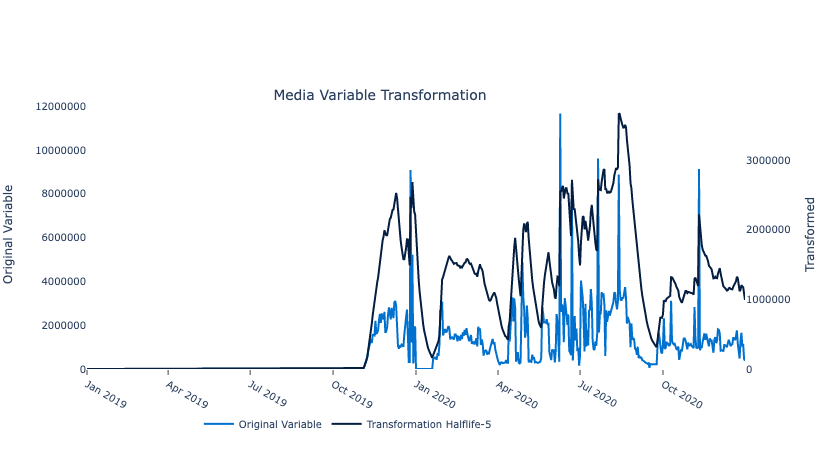

In [55]:
var_trans_obj.visualize_transformation(var, transf_1)

#### Adstock Visualization

In [56]:
# Optional and commented for now (would generate graph almost similar to the above one)
#var_trans_obj.visulaize_adstock(var, transf_1)

#### Visualize S-Curve and C-Curve Scatter Plots

In [57]:
transf_var = var_trans_obj.apply_media_transformations(var= df_model[var], 
                                                     lag= 10, halflife= 10, inflection= 4, scale= 2, 
                                                     lag_toggle= False, halflife_toggle= False,
                                                     scurve_toggle= True, ccurve_toggle= False)

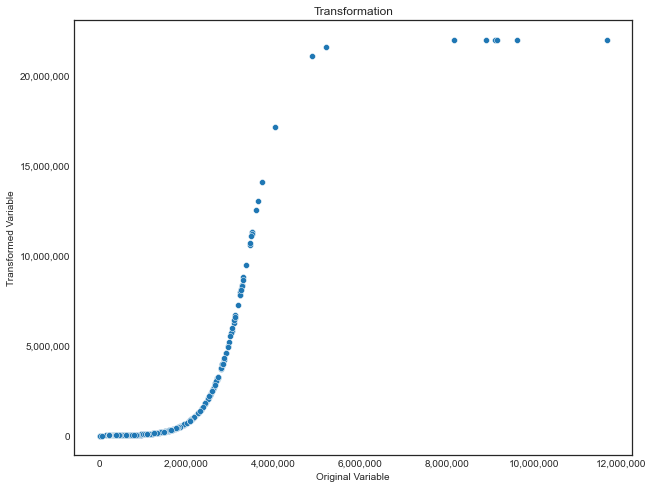

In [58]:
var_trans_obj.visualize_curve_trans(df_model[var], transf_var, original_scale= True)

In [59]:
transf_var = var_trans_obj.apply_media_transformations(var= df_model[var], 
                                                     lag= 10, halflife= 5, inflection= 4, scale= 2, 
                                                     lag_toggle= False, halflife_toggle= False,
                                                     scurve_toggle= True, ccurve_toggle= False)

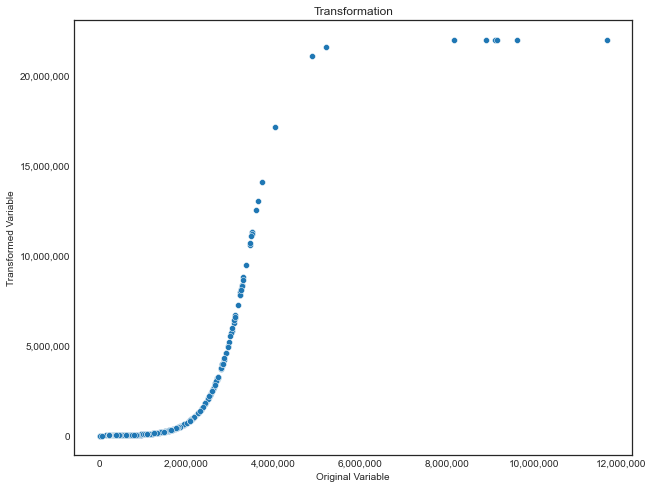

In [60]:
var_trans_obj.visualize_curve_trans(df_model[var], transf_var)

#### Media Variable Transformation

Class VariableTransformation: Performs the most of the media transformations and ranks the transformations
* Inputs parameters to class VariableTransformation:
    * lag_lower and lag_upper: Defines the range of lag. However, only best lag would be selected on the basis of correlation with target variable
        * Prefered Range: 0-14
        
    * max_sponsored_lag: This defines upper limit of lag for Sponsored Media
        * Preferred Value: 4
        
    * halflife_lower and halflife_upper: defined the range of halflife
        * Preferred Range: 0-14
        
    * scale_lower and scale_upper: defines the range of scaling for S-Curve
        * Preferred Range: 0.5-12
        
    * inflection_lower and inflection_upper: defines the range of inflection parameter
        * Prefered Range: 0.5-12
        
    * set the toggles to False to turn off any transformation
        * Preferred: all set to true, except ccurve_toggle
        
###### If user does not specify any particular transformation parameter, above preferred ranges would be automatically selected by default.

<h3><font color='brown'>lag_upper has been changed for online model (i.e. 4). Otherwise, should be set to 14</font></h3>
<h3><font color='brown'>max_sponsored_lag has been changed for online model (i.e. 2). Otherwise, should be set to 4</font></h3>


In [61]:
# running for all the media metrics
# selected_media_vars = ['IMP', 'CLK', 'SPEND']

# running only for impressions & Clicks
selected_media_vars = ['IMP','CLK']

In [62]:
variable_sel_dict

{'IMP': ['Impression',
  ['M_ON_DIS_DOTCOM_CT_OTHER_IMP',
   'M_ON_DIS_DOTCOM_AT_CON_IMP',
   'M_ON_DIS_DOTCOM_AT_CUS_IMP',
   'M_ON_DIS_DOTCOM_KW_OTHER_IMP',
   'M_ON_DIS_DOTCOM_HPLO_IMP',
   'M_ON_DIS_DOTCOM_ROS_IMP',
   'M_ON_DIS_DOTCOM_AT_IMP',
   'M_ON_DIS_DOTCOM_KW_IMP',
   'M_ON_DIS_DOTCOM_CT_IMP',
   'M_ON_DIS_DOTCOM_IMP',
   'M_ON_DIS_CT_OTHER_IMP',
   'M_ON_DIS_CT_IMP',
   'M_ON_DIS_AT_CON_IMP',
   'M_ON_DIS_AT_CUS_IMP',
   'M_ON_DIS_AT_IMP',
   'M_ON_DIS_KW_OTHER_IMP',
   'M_ON_DIS_KW_IMP',
   'M_ON_DIS_HPLO_IMP',
   'M_ON_DIS_ROS_IMP',
   'M_SP_OG_AB_IMP',
   'M_SP_DOTCOM_AB_IMP',
   'M_SP_OG_KWB_IMP',
   'M_SP_DOTCOM_KWB_IMP',
   'M_SP_OG_IMP',
   'M_SP_DOTCOM_IMP',
   'M_SP_AB_IMP',
   'M_SP_KWB_IMP',
   'M_SP_IMP',
   'M_SBA_DOTCOM_IMP',
   'M_SBA_IMP',
   'M_OFF_DIS_WN_IMP',
   'M_OFF_DIS_OG_WN_DISPLAY_IMP',
   'M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP',
   'M_OFF_DIS_OG_WN_IMP',
   'M_OFF_DIS_DOTCOM_WN_IMP',
   'M_OFF_DIS_WN_DISPLAY_IMP',
   'M_ON_DIS_OTHERS_IMP',
   'M_ON_DIS_

M_ON_DIS_DOTCOM_CT_OTHER_IMP
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.022226
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.021113
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.003622
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.004615
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.008697
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.057464
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.272906
dtype: float64
const                           0.00000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.02059
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.014616
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_CT_OTHER_IMP    0.006196
dtype: float64
con

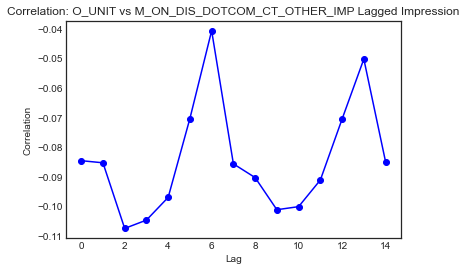

Best Lag for M_ON_DIS_DOTCOM_CT_OTHER_IMP : [ 6. 13.  5.]
*****************************************************************
M_ON_DIS_DOTCOM_AT_CON_IMP
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.036173
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.065954
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.130698
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.187725
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.030249
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.024732
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.033647
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.015656
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CON_IMP    0.041234
dtype: float64
const       

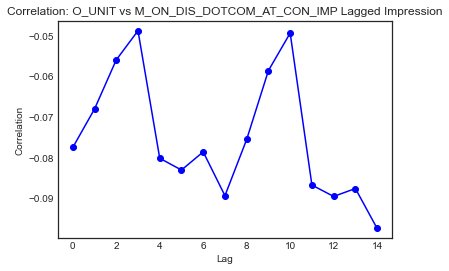

Best Lag for M_ON_DIS_DOTCOM_AT_CON_IMP : [ 3. 10.  2.]
*****************************************************************
M_ON_DIS_DOTCOM_AT_CUS_IMP
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.004298
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.016807
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.023004
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.018937
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.001607
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.001141
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.001508
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.004035
dtype: float64
const                         0.000000
M_ON_DIS_DOTCOM_AT_CUS_IMP    0.016297
dtype: float64
const         

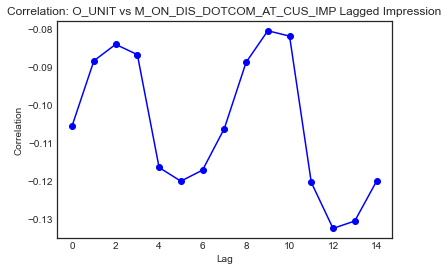

Best Lag for M_ON_DIS_DOTCOM_AT_CUS_IMP : [ 9. 10.  2.]
*****************************************************************
M_ON_DIS_DOTCOM_KW_OTHER_IMP
const                           0.00000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.42625
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.335608
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.441897
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.722197
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.702073
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.880204
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.695113
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.359506
dtype: float64
const                           0.000000
M_ON_DIS_DOTCOM_KW_OTHER_IMP    0.

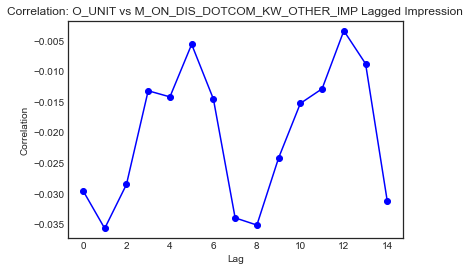

Best Lag for M_ON_DIS_DOTCOM_KW_OTHER_IMP : [12.  5. 13.]
*****************************************************************
M_ON_DIS_DOTCOM_HPLO_IMP
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.300978
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.387586
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.392522
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.853741
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.922722
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.391147
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.780131
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.558793
dtype: float64
const                       0.000000
M_ON_DIS_DOTCOM_HPLO_IMP    0.830895
dtype: float64
const                       0.000000
M_ON_DIS_DOTC

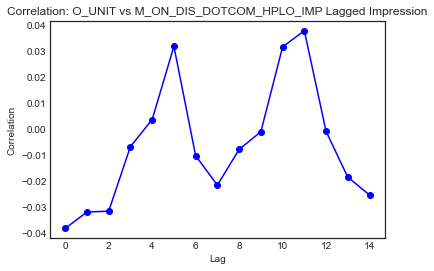

Best Lag for M_ON_DIS_DOTCOM_HPLO_IMP : [11.  5. 10.]
*****************************************************************
M_ON_DIS_DOTCOM_ROS_IMP
const                      0.00000
M_ON_DIS_DOTCOM_ROS_IMP    0.00527
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.002214
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.008651
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.010899
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.015704
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.009934
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.001305
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.000546
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.001707
dtype: float64
const                      0.000000
M_ON_DIS_DOTCOM_ROS_IMP    0.008717
dty

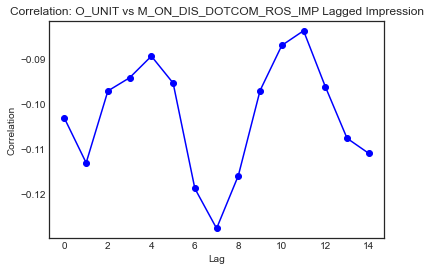

Best Lag for M_ON_DIS_DOTCOM_ROS_IMP : [11. 10.  4.]
*****************************************************************
M_ON_DIS_DOTCOM_AT_IMP
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.004512
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.017097
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.024537
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.021336
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.001773
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.001263
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.001691
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.003925
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_AT_IMP    0.015902
dtype: float64
const                     0.00000
M_ON_DIS_DOTCOM_AT_IMP    0.03052
dtype: float64
const     

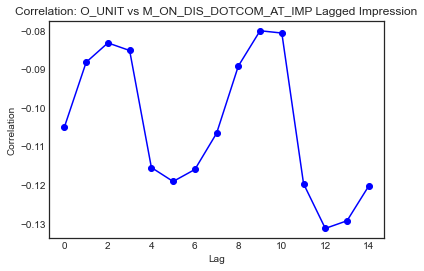

Best Lag for M_ON_DIS_DOTCOM_AT_IMP : [ 9. 10.  2.]
*****************************************************************
M_ON_DIS_DOTCOM_KW_IMP
const                     0.00000
M_ON_DIS_DOTCOM_KW_IMP    0.42625
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.335608
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.441897
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.722197
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.702073
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.880204
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.695113
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.359506
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.343081
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_KW_IMP    0.514569
dtype: float64
const      

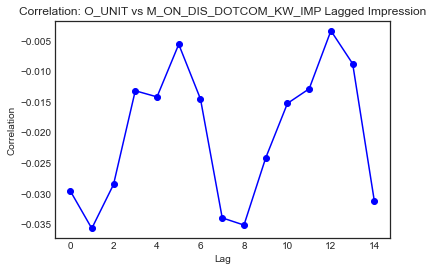

Best Lag for M_ON_DIS_DOTCOM_KW_IMP : [12.  5. 13.]
*****************************************************************
M_ON_DIS_DOTCOM_CT_IMP
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.022226
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.021113
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.003622
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.004615
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.008697
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.057464
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.272906
dtype: float64
const                     0.00000
M_ON_DIS_DOTCOM_CT_IMP    0.02059
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.014616
dtype: float64
const                     0.000000
M_ON_DIS_DOTCOM_CT_IMP    0.006196
dtype: float64
const      

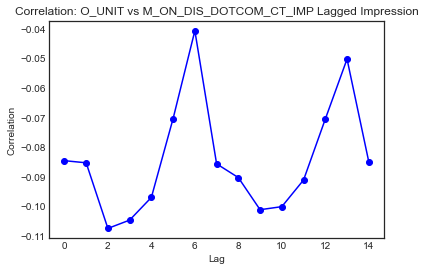

Best Lag for M_ON_DIS_DOTCOM_CT_IMP : [ 6. 13.  5.]
*****************************************************************
M_ON_DIS_DOTCOM_IMP
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.053971
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.093218
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.104513
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.315747
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.354909
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.816651
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.196755
dtype: float64
const                  0.00000
M_ON_DIS_DOTCOM_IMP    0.11667
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.275851
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.406901
dtype: float64
const                  0.000000
M_ON_DIS_DOTCOM_IMP    0.994777
dtype: flo

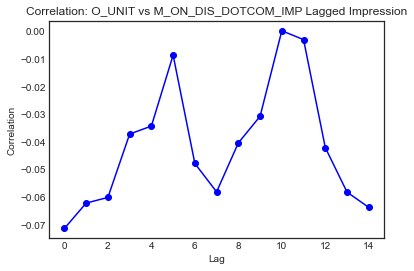

Best Lag for M_ON_DIS_DOTCOM_IMP : [10. 11.  5.]
*****************************************************************
M_ON_DIS_CT_OTHER_IMP
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.022226
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.021113
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.003622
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.004615
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.008697
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.057464
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.272906
dtype: float64
const                    0.00000
M_ON_DIS_CT_OTHER_IMP    0.02059
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.014616
dtype: float64
const                    0.000000
M_ON_DIS_CT_OTHER_IMP    0.006196
dtype: float64
const                    0.000000
M

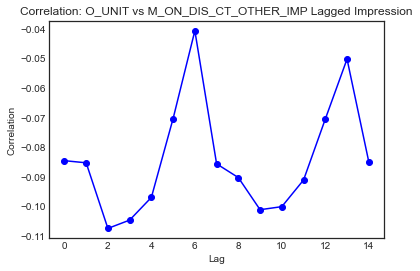

Best Lag for M_ON_DIS_CT_OTHER_IMP : [ 6. 13.  5.]
*****************************************************************
M_ON_DIS_CT_IMP
const              0.000000
M_ON_DIS_CT_IMP    0.022226
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.021113
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.003622
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.004615
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.008697
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.057464
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.272906
dtype: float64
const              0.00000
M_ON_DIS_CT_IMP    0.02059
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.014616
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.006196
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.006751
dtype: float64
const              0.000000
M_ON_DIS_CT_IMP    0.013744
dtype: float64
const            

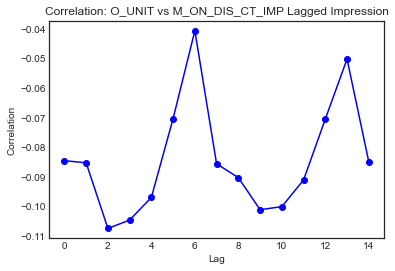

Best Lag for M_ON_DIS_CT_IMP : [ 6. 13.  5.]
*****************************************************************
M_ON_DIS_AT_CON_IMP
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.036173
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.065954
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.130698
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.187725
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.030249
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.024732
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.033647
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.015656
dtype: float64
const                  0.000000
M_ON_DIS_AT_CON_IMP    0.041234
dtype: float64
const                  0.00000
M_ON_DIS_AT_CON_IMP    0.11356
dtype: float64
const                  0.0000
M_ON_DIS_AT_CON_IMP    0.1826
dtype: float64
const 

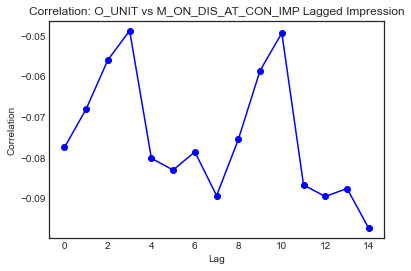

Best Lag for M_ON_DIS_AT_CON_IMP : [ 3. 10.  2.]
*****************************************************************
M_ON_DIS_AT_CUS_IMP
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.004298
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.016807
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.023004
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.018937
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.001607
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.001141
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.001508
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.004035
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.016297
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.029536
dtype: float64
const                  0.000000
M_ON_DIS_AT_CUS_IMP    0.026786
dtype: floa

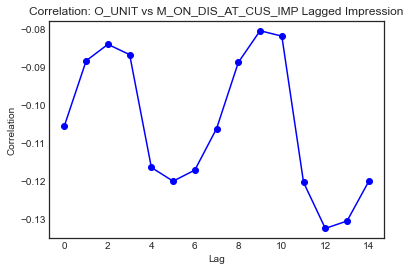

Best Lag for M_ON_DIS_AT_CUS_IMP : [ 9. 10.  2.]
*****************************************************************
M_ON_DIS_AT_IMP
const              0.000000
M_ON_DIS_AT_IMP    0.004512
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.017097
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.024537
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.021336
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.001773
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.001263
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.001691
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.003925
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.015902
dtype: float64
const              0.00000
M_ON_DIS_AT_IMP    0.03052
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.029298
dtype: float64
const              0.000000
M_ON_DIS_AT_IMP    0.001193
dtype: float64
const              

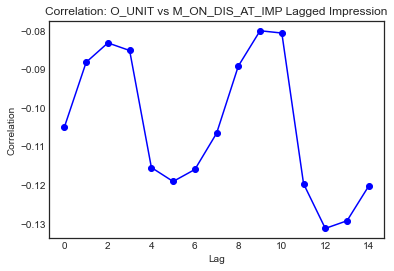

Best Lag for M_ON_DIS_AT_IMP : [ 9. 10.  2.]
*****************************************************************
M_ON_DIS_KW_OTHER_IMP
const                    0.00000
M_ON_DIS_KW_OTHER_IMP    0.42625
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.335608
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.441897
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.722197
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.702073
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.880204
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.695113
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.359506
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.343081
dtype: float64
const                    0.000000
M_ON_DIS_KW_OTHER_IMP    0.514569
dtype: float64
const                    0.00000
M_ON_D

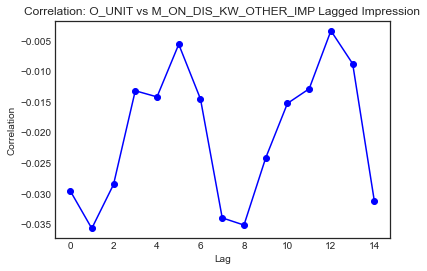

Best Lag for M_ON_DIS_KW_OTHER_IMP : [12.  5. 13.]
*****************************************************************
M_ON_DIS_KW_IMP
const              0.00000
M_ON_DIS_KW_IMP    0.42625
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.335608
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.441897
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.722197
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.702073
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.880204
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.695113
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.359506
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.343081
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.514569
dtype: float64
const              0.00000
M_ON_DIS_KW_IMP    0.68086
dtype: float64
const              0.000000
M_ON_DIS_KW_IMP    0.728754
dtype: float64
const              

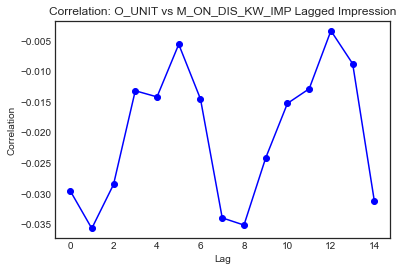

Best Lag for M_ON_DIS_KW_IMP : [12.  5. 13.]
*****************************************************************
M_ON_DIS_HPLO_IMP
const                0.000000
M_ON_DIS_HPLO_IMP    0.300978
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.387586
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.392522
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.853741
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.922722
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.391147
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.780131
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.558793
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.830895
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.976412
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IMP    0.394382
dtype: float64
const                0.000000
M_ON_DIS_HPLO_IM

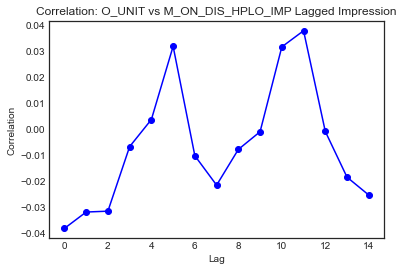

Best Lag for M_ON_DIS_HPLO_IMP : [11.  5. 10.]
*****************************************************************
M_ON_DIS_ROS_IMP
const               0.00000
M_ON_DIS_ROS_IMP    0.00527
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.002214
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.008651
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.010899
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.015704
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.009934
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.001305
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.000546
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.001707
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.008717
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.018719
dtype: float64
const               0.000000
M_ON_DIS_ROS_IMP    0.023649
dtype: floa

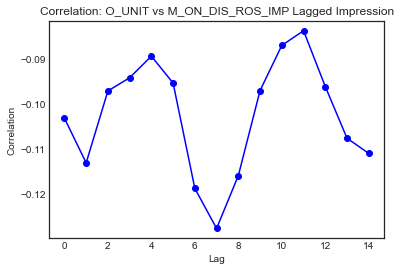

Best Lag for M_ON_DIS_ROS_IMP : [11. 10.  4.]
*****************************************************************
M_SP_OG_AB_IMP
const             0.000000
M_SP_OG_AB_IMP    0.113388
dtype: float64
const             0.000000
M_SP_OG_AB_IMP    0.107673
dtype: float64
const             0.000000
M_SP_OG_AB_IMP    0.051388
dtype: float64
const             0.000000
M_SP_OG_AB_IMP    0.034392
dtype: float64
const             0.000000
M_SP_OG_AB_IMP    0.034099
dtype: float64


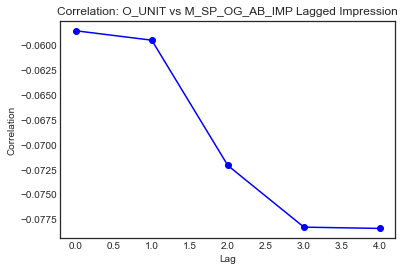

Best Lag for M_SP_OG_AB_IMP : [0. 1. 2.]
*****************************************************************
M_SP_DOTCOM_AB_IMP
const                 0.000000
M_SP_DOTCOM_AB_IMP    0.689117
dtype: float64
const                 0.000000
M_SP_DOTCOM_AB_IMP    0.466791
dtype: float64
const                 0.00000
M_SP_DOTCOM_AB_IMP    0.31482
dtype: float64
const                 0.000000
M_SP_DOTCOM_AB_IMP    0.221447
dtype: float64
const                 0.000000
M_SP_DOTCOM_AB_IMP    0.110841
dtype: float64


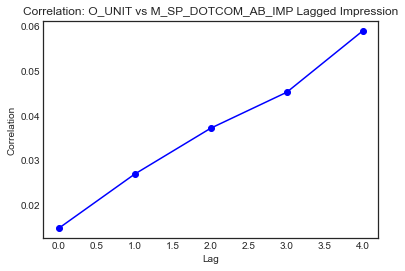

Best Lag for M_SP_DOTCOM_AB_IMP : [4. 3. 2.]
*****************************************************************
M_SP_OG_KWB_IMP
const              0.000000e+00
M_SP_OG_KWB_IMP    4.435337e-10
dtype: float64
const              0.000000e+00
M_SP_OG_KWB_IMP    1.001904e-09
dtype: float64
const              0.000000e+00
M_SP_OG_KWB_IMP    4.484665e-10
dtype: float64
const              0.000000e+00
M_SP_OG_KWB_IMP    2.129726e-10
dtype: float64
const              0.000000e+00
M_SP_OG_KWB_IMP    5.969294e-11
dtype: float64


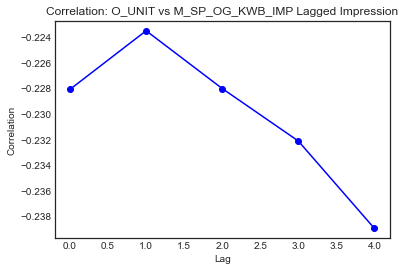

Best Lag for M_SP_OG_KWB_IMP : [1. 2. 0.]
*****************************************************************
M_SP_DOTCOM_KWB_IMP
const                  0.000000
M_SP_DOTCOM_KWB_IMP    0.000013
dtype: float64
const                  0.000000
M_SP_DOTCOM_KWB_IMP    0.000058
dtype: float64
const                  0.000000
M_SP_DOTCOM_KWB_IMP    0.000051
dtype: float64
const                  0.000000
M_SP_DOTCOM_KWB_IMP    0.000015
dtype: float64
const                  0.000000
M_SP_DOTCOM_KWB_IMP    0.000008
dtype: float64


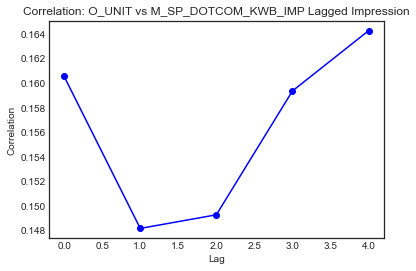

Best Lag for M_SP_DOTCOM_KWB_IMP : [4. 0. 3.]
*****************************************************************
M_SP_OG_IMP
const          0.00000
M_SP_OG_IMP    0.10556
dtype: float64
const          0.000000
M_SP_OG_IMP    0.100313
dtype: float64
const          0.000000
M_SP_OG_IMP    0.047317
dtype: float64
const          0.000000
M_SP_OG_IMP    0.031472
dtype: float64
const          0.000000
M_SP_OG_IMP    0.031139
dtype: float64


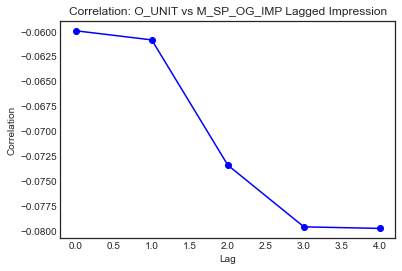

Best Lag for M_SP_OG_IMP : [0. 1. 2.]
*****************************************************************
M_SP_DOTCOM_IMP
const              0.000000
M_SP_DOTCOM_IMP    0.671507
dtype: float64
const              0.000000
M_SP_DOTCOM_IMP    0.454103
dtype: float64
const              0.000000
M_SP_DOTCOM_IMP    0.305259
dtype: float64
const              0.000000
M_SP_DOTCOM_IMP    0.213657
dtype: float64
const              0.000000
M_SP_DOTCOM_IMP    0.106363
dtype: float64


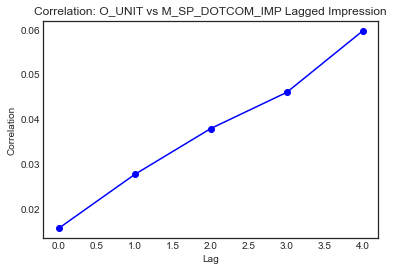

Best Lag for M_SP_DOTCOM_IMP : [4. 3. 2.]
*****************************************************************
M_SP_AB_IMP
const          0.000000
M_SP_AB_IMP    0.232536
dtype: float64
const          0.000000
M_SP_AB_IMP    0.302765
dtype: float64
const          0.000000
M_SP_AB_IMP    0.239231
dtype: float64
const          0.000000
M_SP_AB_IMP    0.228918
dtype: float64
const          0.000000
M_SP_AB_IMP    0.319373
dtype: float64


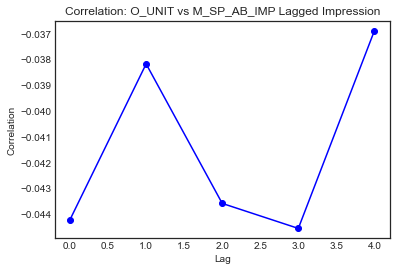

Best Lag for M_SP_AB_IMP : [4. 1. 2.]
*****************************************************************
M_SP_KWB_IMP
const           0.00000
M_SP_KWB_IMP    0.00243
dtype: float64
const           0.000000
M_SP_KWB_IMP    0.001852
dtype: float64
const           0.000000
M_SP_KWB_IMP    0.001346
dtype: float64
const           0.000000
M_SP_KWB_IMP    0.001767
dtype: float64
const           0.00000
M_SP_KWB_IMP    0.00143
dtype: float64


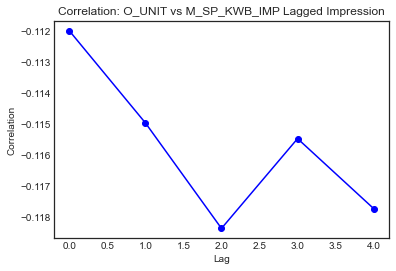

Best Lag for M_SP_KWB_IMP : [0. 1. 3.]
*****************************************************************
M_SP_IMP
const       0.000000
M_SP_IMP    0.226196
dtype: float64
const       0.000000
M_SP_IMP    0.294856
dtype: float64
const       0.000000
M_SP_IMP    0.232365
dtype: float64
const       0.000000
M_SP_IMP    0.222478
dtype: float64
const       0.000000
M_SP_IMP    0.311039
dtype: float64


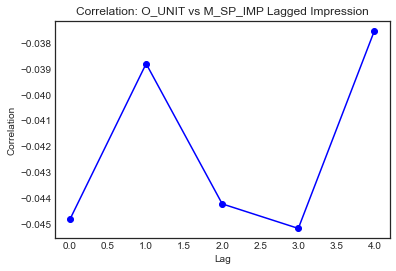

Best Lag for M_SP_IMP : [4. 1. 2.]
*****************************************************************
M_SBA_DOTCOM_IMP
const               0.000000
M_SBA_DOTCOM_IMP    0.009326
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.001529
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.005906
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.065206
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.213653
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.325237
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.173569
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.023494
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.004172
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.009248
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.033607
dtype: float64
const               0.000000
M_SBA_DOTCOM_IMP    0.049617
dtype: float64
const 

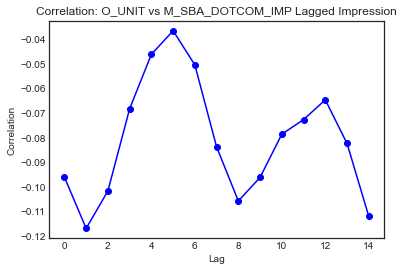

Best Lag for M_SBA_DOTCOM_IMP : [5. 4. 6.]
*****************************************************************
M_SBA_IMP
const        0.000000
M_SBA_IMP    0.009326
dtype: float64
const        0.000000
M_SBA_IMP    0.001529
dtype: float64
const        0.000000
M_SBA_IMP    0.005906
dtype: float64
const        0.000000
M_SBA_IMP    0.065206
dtype: float64
const        0.000000
M_SBA_IMP    0.213653
dtype: float64
const        0.000000
M_SBA_IMP    0.325237
dtype: float64
const        0.000000
M_SBA_IMP    0.173569
dtype: float64
const        0.000000
M_SBA_IMP    0.023494
dtype: float64
const        0.000000
M_SBA_IMP    0.004172
dtype: float64
const        0.000000
M_SBA_IMP    0.009248
dtype: float64
const        0.000000
M_SBA_IMP    0.033607
dtype: float64
const        0.000000
M_SBA_IMP    0.049617
dtype: float64
const        0.00000
M_SBA_IMP    0.08089
dtype: float64
const        0.000000
M_SBA_IMP    0.025926
dtype: float64
const        0.000000
M_SBA_IMP    0.002409
dtype: float6

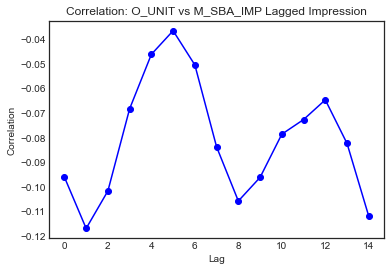

Best Lag for M_SBA_IMP : [5. 4. 6.]
*****************************************************************
M_OFF_DIS_WN_IMP
const               0.000000
M_OFF_DIS_WN_IMP    0.007144
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.001332
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.003463
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.023126
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.157322
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.522376
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.327064
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.055744
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.023422
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.035775
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.051395
dtype: float64
const               0.000000
M_OFF_DIS_WN_IMP    0.338618
dtype: float64
const

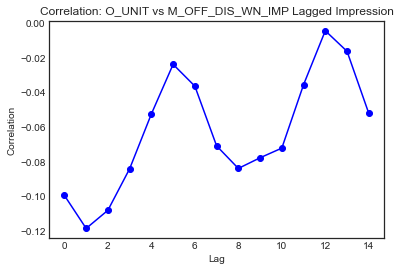

Best Lag for M_OFF_DIS_WN_IMP : [12. 13.  5.]
*****************************************************************
M_OFF_DIS_OG_WN_DISPLAY_IMP
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.005903
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.000707
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.001083
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.003072
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.011766
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.019839
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.023618
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.011589
dtype: float64
const                          0.000000
M_OFF_DIS_OG_WN_DISPLAY_IMP    0.001854
dtype: float64
const

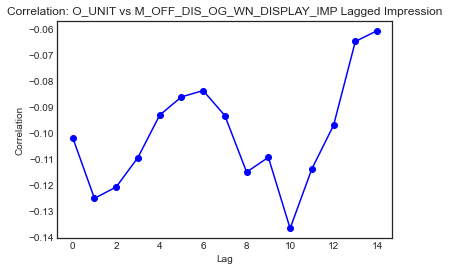

Best Lag for M_OFF_DIS_OG_WN_DISPLAY_IMP : [14. 13.  6.]
*****************************************************************
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.093545
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.050777
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.089371
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.257449
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.687147
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.725424
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.962468
dtype: float64
const                              0.000000
M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP    0.347258
dtype: float64
const                

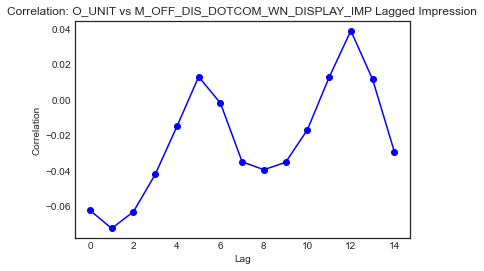

Best Lag for M_OFF_DIS_DOTCOM_WN_DISPLAY_IMP : [12.  5. 11.]
*****************************************************************
M_OFF_DIS_OG_WN_IMP
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.005903
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.000707
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.001083
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.003072
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.011766
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.019839
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.023618
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.011589
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.001854
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.003092
dtype: float64
const                  0.000000
M_OFF_DIS_OG_WN_IMP    0.000214

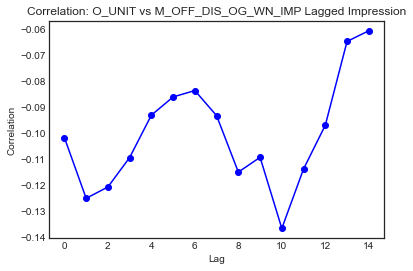

Best Lag for M_OFF_DIS_OG_WN_IMP : [14. 13.  6.]
*****************************************************************
M_OFF_DIS_DOTCOM_WN_IMP
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.093545
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.050777
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.089371
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.257449
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.687147
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.725424
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.962468
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.347258
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.289419
dtype: float64
const                      0.000000
M_OFF_DIS_DOTCOM_WN_IMP    0.343272
dtype:

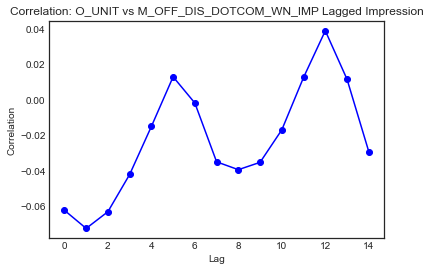

Best Lag for M_OFF_DIS_DOTCOM_WN_IMP : [12.  5. 11.]
*****************************************************************
M_OFF_DIS_WN_DISPLAY_IMP
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.007144
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.001332
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.003463
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.023126
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.157322
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.522376
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.327064
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.055744
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPLAY_IMP    0.023422
dtype: float64
const                       0.000000
M_OFF_DIS_WN_DISPL

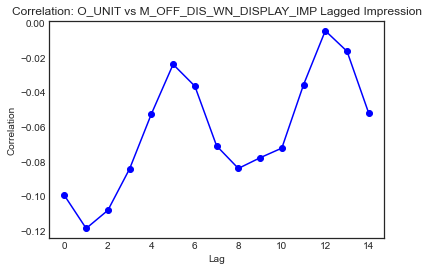

Best Lag for M_OFF_DIS_WN_DISPLAY_IMP : [12. 13.  5.]
*****************************************************************
M_ON_DIS_OTHERS_IMP
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.210118
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.269285
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.288529
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.700299
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.925046
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.514194
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.594812
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.391581
dtype: float64
const                  0.00000
M_ON_DIS_OTHERS_IMP    0.64439
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.812517
dtype: float64
const                  0.000000
M_ON_DIS_OTHERS_IMP    0.506879
dtype: f

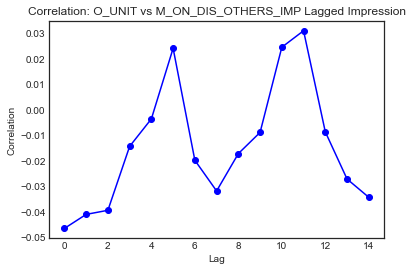

Best Lag for M_ON_DIS_OTHERS_IMP : [11. 10.  5.]
*****************************************************************
M_ON_DIS_TOTAL_IMP
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.053971
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.093218
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.104513
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.315747
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.354909
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.816651
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.196755
dtype: float64
const                 0.00000
M_ON_DIS_TOTAL_IMP    0.11667
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.275851
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.406901
dtype: float64
const                 0.000000
M_ON_DIS_TOTAL_IMP    0.994777
dtype: float64
const                

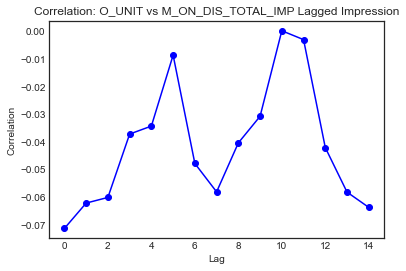

Best Lag for M_ON_DIS_TOTAL_IMP : [10. 11.  5.]
*****************************************************************
M_OFF_DIS_TOTAL_IMP
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.007144
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.001332
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.003463
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.023126
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.157322
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.522376
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.327064
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.055744
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.023422
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.035775
dtype: float64
const                  0.000000
M_OFF_DIS_TOTAL_IMP    0.051395
dtype: float

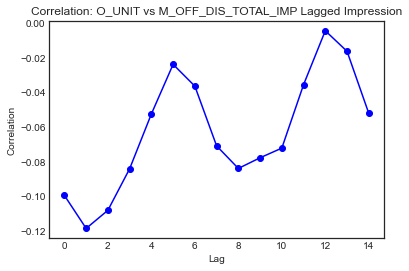

Best Lag for M_OFF_DIS_TOTAL_IMP : [12. 13.  5.]
*****************************************************************
M_TOTAL_DISPLAY_IMP
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.025505
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.040027
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.049596
dtype: float64
const                  0.00000
M_TOTAL_DISPLAY_IMP    0.20361
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.276858
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.757939
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.163571
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.074477
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.175162
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.280758
dtype: float64
const                  0.000000
M_TOTAL_DISPLAY_IMP    0.812763
dtype: float6

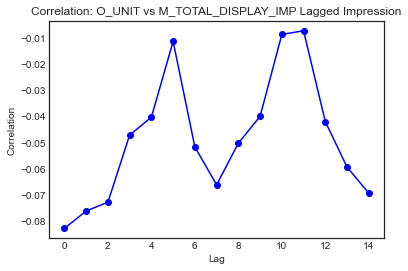

Best Lag for M_TOTAL_DISPLAY_IMP : [11. 10.  5.]
*****************************************************************
M_TOTAL_MEDIA_IMP
const                0.000000
M_TOTAL_MEDIA_IMP    0.024748
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.043084
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.038694
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.098675
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.164913
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.629729
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.242216
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.084896
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.172084
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.207593
dtype: float64
const                0.000000
M_TOTAL_MEDIA_IMP    0.419615
dtype: float64
const                0.000000
M_TOTAL_MEDI

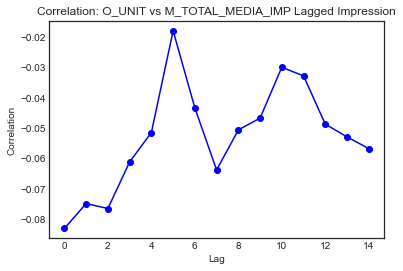

Best Lag for M_TOTAL_MEDIA_IMP : [ 5. 10. 11.]
*****************************************************************
M_SEARCH_IMP
const           0.000000
M_SEARCH_IMP    0.219213
dtype: float64
const           0.000000
M_SEARCH_IMP    0.284004
dtype: float64
const           0.000000
M_SEARCH_IMP    0.224729
dtype: float64
const           0.000000
M_SEARCH_IMP    0.218028
dtype: float64
const           0.000000
M_SEARCH_IMP    0.307553
dtype: float64
const           0.000000
M_SEARCH_IMP    0.677716
dtype: float64
const           0.000000
M_SEARCH_IMP    0.660018
dtype: float64
const           0.000000
M_SEARCH_IMP    0.376421
dtype: float64
const           0.000000
M_SEARCH_IMP    0.451875
dtype: float64
const           0.000000
M_SEARCH_IMP    0.397356
dtype: float64
const           0.000000
M_SEARCH_IMP    0.346142
dtype: float64
const           0.000000
M_SEARCH_IMP    0.277189
dtype: float64
const           0.000000
M_SEARCH_IMP    0.380535
dtype: float64
const           0.000000
M_SE

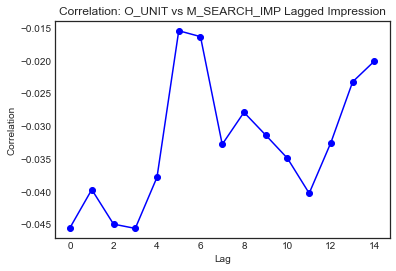

Best Lag for M_SEARCH_IMP : [ 5.  6. 14.]
*****************************************************************
M_ON_DIS_AT_CT_IMP
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.003562
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.012708
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.014911
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.013305
dtype: float64
const                 0.00000
M_ON_DIS_AT_CT_IMP    0.00128
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.001246
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.002246
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.003087
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.011339
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.019557
dtype: float64
const                 0.000000
M_ON_DIS_AT_CT_IMP    0.018949
dtype: float64
const                 0.0000

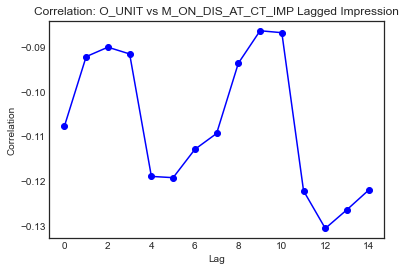

Best Lag for M_ON_DIS_AT_CT_IMP : [ 9. 10.  2.]
*****************************************************************
M_ON_DIS_AT_ROS_IMP
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.001047
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.003242
dtype: float64
const                  0.00000
M_ON_DIS_AT_ROS_IMP    0.00681
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.006293
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.000601
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.000367
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.000253
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.000473
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.002813
dtype: float64
const                  0.000000
M_ON_DIS_AT_ROS_IMP    0.008574
dtype: float64
const                  0.00000
M_ON_DIS_AT_ROS_IMP    0.01017
dtype: float64
c

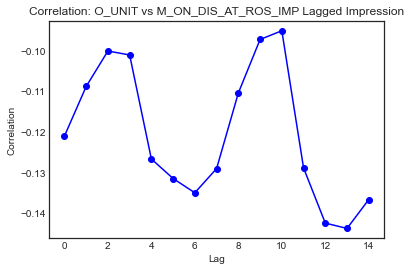

Best Lag for M_ON_DIS_AT_ROS_IMP : [10.  9.  2.]
*****************************************************************
M_ON_DIS_CT_ROS_IMP
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.001099
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.000452
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.000826
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.001168
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.002235
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.003299
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.001351
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.000114
dtype: float64
const                  0.00000
M_ON_DIS_CT_ROS_IMP    0.00029
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.001039
dtype: float64
const                  0.000000
M_ON_DIS_CT_ROS_IMP    0.002437
dtype: float6

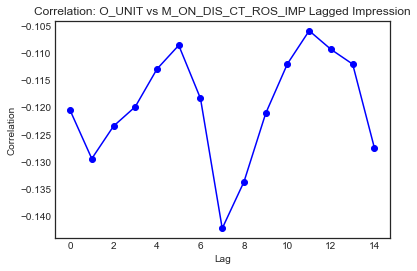

Best Lag for M_ON_DIS_CT_ROS_IMP : [11.  5. 12.]
*****************************************************************
M_ON_DIS_KW_ROS_IMP
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.004907
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.002017
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.008103
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.010577
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.015228
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.009801
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.001253
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.000495
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.001555
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.008246
dtype: float64
const                  0.000000
M_ON_DIS_KW_ROS_IMP    0.018125
dtype: floa

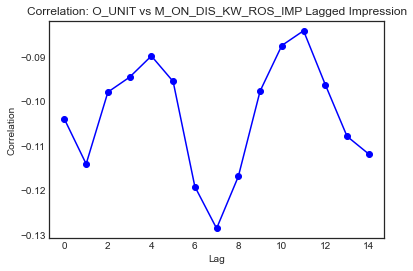

Best Lag for M_ON_DIS_KW_ROS_IMP : [11. 10.  4.]
*****************************************************************
M_ON_DIS_ROS_HPLO_IMP
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.300978
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.387586
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.392522
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.853741
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.922722
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.391147
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.780131
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.558793
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.830895
dtype: float64
const                    0.000000
M_ON_DIS_ROS_HPLO_IMP    0.976412
dtype: float64
const                    0.000000

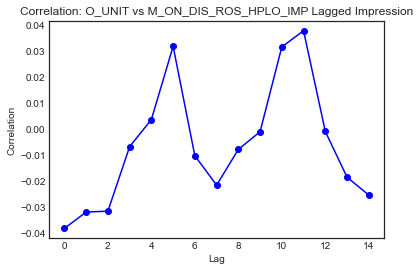

Best Lag for M_ON_DIS_ROS_HPLO_IMP : [11.  5. 10.]
*****************************************************************
['O_UNIT_SARIMAX (1, 1, 0) (2, 0, 1, 7)', 'D_HOL_CHRISTMAS', 'D_HOL_THANKSGIVING', 'D_HOL_NEW_YEARS_DAY', 'D_HOL_EASTER', 'D_HOL_SUPER_BOWL', 'D_EVENT_POST_CHRISTMAS', 'D_DAY_SATURDAY', 'D_DAY_WEDNESDAY', 'D_EVENT_COVID_LOCKDOWN', 'D_DAY_TUESDAY', 'D_DAY_SUNDAY', 'PRICE', 'BRAND_DISTRIBUTION_TDP']
*****************************************************************
Processing for Variable: M_ON_DIS_DOTCOM_CT_OTHER_IMP
Total Transformations 15552
*****************************************************************
Processing for Variable: M_ON_DIS_DOTCOM_AT_CON_IMP
Total Transformations 10368
*****************************************************************
Processing for Variable: M_ON_DIS_DOTCOM_AT_CUS_IMP
Total Transformations 13824
*****************************************************************
Processing for Variable: M_ON_DIS_DOTCOM_KW_OTHER_IMP
Total Transformations 19

In [ ]:
%%time

for key, value in variable_sel_dict.items():
    if key not in selected_media_vars:
        continue
        
    all_media_imp_valid = value[1]
    metric_name = value[0].lower()
    
    # Creating an object of the class
    var_trans_obj_sales_units = VariableTransformation(df_model, data_dict, lag_lower= 0, lag_upper= 14,
                                                         max_sponsored_lag = 4,
                                                         halflife_lower= 0, halflife_upper= 14, 
                                                         scale_lower= 0.5, scale_upper= 12,
                                                         inflection_lower= 0.5, inflection_upper= 12,
                                                         lag_toggle= True, halflife_toggle= True,
                                                         scurve_toggle= True, ccurve_toggle= False,
                                                         apply_adstock = apply_adstock
                                                      )

    # Function to calculate best lag for each of the media variable
    var_trans_obj_sales_units.find_best_lag(units_target_var, all_media_imp_valid)

    excel_obj = SaveExcelTemplated(units_path + "lag_analysis_{}.xlsx".format(metric_name))

    for key, value in var_trans_obj_sales_units.var_lag_analysis.items():
        excel_obj.add_worksheet(value, key, decimal_5_col_names= value.columns[1:])
    excel_obj.save_worksheet()

    ###### Flexibility options in method find_best_trans_all_vars
    # * additional_indep_vars: List of additional indepependent variables like Seasonality 
    # * intercept (boolean): can be set to False if intercept term is not required in Linear Regression Equation
    # * mape, pval, corr, aic, r_sq, r_sq_adj, bic: Once set to False, the metric would be excluded from final ranking
    # These are additional terms that would be added as independent variables while linear regression
    seas_ar_units_cols = [col for col in df_model.columns if (col.startswith(units_target_var + '_SAR')) & ('LOG' not in col)] # +['D_NATIONAL_WEATHER']
    seas_ar_units_cols += ['D_HOL_CHRISTMAS','D_HOL_THANKSGIVING','D_HOL_NEW_YEARS_DAY'
                          ,'D_HOL_EASTER','D_HOL_SUPER_BOWL','D_EVENT_POST_CHRISTMAS','D_DAY_SATURDAY',
                          'D_DAY_WEDNESDAY','D_EVENT_COVID_LOCKDOWN','D_DAY_TUESDAY','D_DAY_SUNDAY',
                          'PRICE','BRAND_DISTRIBUTION_TDP',
                           # the below variables do not exist in the dataframe
#                            'D_EVENT_PRE_SUPERBOWL', 'D_EVENT_COVID_STOCKUP','D_EVENT_STORE_FEATURE','Colgate_O_PRICE',
#                            'O_CAT_ORAL CARE_O_UNIT','Crest_MEDIA_SPEND', 
#                            'D_EVENT_COVID_BURN', 'Crest_O_PRICE','Colgate_MEDIA_SPEND',
                           ]
    

    
    print(seas_ar_units_cols)

    # additional_indep_vars: pass list of seasonality terms that will be included in the model
    # include_other_media: work in progress to improve automation flow. can be False for now. 
    var_trans_obj_sales_units.find_best_trans_all_vars(units_target_var, all_media_imp_valid, 
                                                       additional_indep_vars=seas_ar_units_cols,
                                                       include_other_media= False)

    var_trans_obj_sales_units.save_excel_output(os.path.normpath(units_path + "media_transformations_{}.xlsx".format(metric_name)),
                                   decimal_col_names= decimal_3_col_names,
                                   decimal_5_col_names= decimal_5_col_names,
                                   scientific_col_names= scientific_col_names)

### Media Transformation : New Customer

In [ ]:
%%time

for key, value in variable_sel_dict.items():
    if key not in selected_media_vars:
        continue
        
    all_media_imp_valid = value[1]
    metric_name = value[0].lower()
    
    var_trans_obj_new_cust = VariableTransformation(df_model, data_dict, lag_lower= 0, lag_upper= 14,
                                         max_sponsored_lag = 4,
                                         halflife_lower= 0, halflife_upper= 14, 
                                         scale_lower= 0.5, scale_upper= 12,
                                         inflection_lower= 0.5, inflection_upper= 12,
                                         lag_toggle= True, halflife_toggle= True,
                                         scurve_toggle= True, ccurve_toggle= False,
                                         apply_adstock = apply_adstock,
                                                   )

    var_trans_obj_new_cust.find_best_lag(cust_target_var, all_media_imp_valid)


    excel_obj = SaveExcelTemplated(cust_path + "lag_analysis_{}.xlsx".format(metric_name))

    for key, value in var_trans_obj_new_cust.var_lag_analysis.items():
        excel_obj.add_worksheet(value, key, decimal_5_col_names= value.columns[1:])
    excel_obj.save_worksheet()

    seas_ar_cust_cols = [col for col in df_model.columns if (col.startswith(cust_target_var + '_SAR')) & ('LOG' not in col)]
    seas_ar_cust_cols += ['D_HOL_CHRISTMAS','D_HOL_THANKSGIVING','D_HOL_NEW_YEARS_DAY'
                          ,'D_HOL_EASTER','D_HOL_SUPER_BOWL','D_EVENT_POST_CHRISTMAS','D_DAY_SATURDAY',
                          'D_DAY_WEDNESDAY','D_EVENT_COVID_LOCKDOWN',
                              # the below variables do not exist in the dataframe
#                           'D_EVENT_PRE_SUPERBOWL','D_EVENT_COVID_STOCKUP','D_EVENT_STORE_FEATURE',
#                           'D_EVENT_EXTREME_COLD','Colgate_O_PRICE','O_CAT_ORAL CARE_O_UNIT','D_EVENT_PRODUCT_LAUNCH',
#                           'Crest_MEDIA_SPEND', 'D_NATIONAL_WEATHER','D_EVENT_COVID_BURN','Crest_O_PRICE','Colgate_MEDIA_SPEND',
                          'D_DAY_TUESDAY','D_DAY_SUNDAY','D_HOL_LABOR_DAY','D_HOL_MONTHER_DAY','D_HOL_FATHER_DAY',
                          'D_HOL_MEMORIAL_DAY','D_EVENT_HOLIDAYS','D_DAY_MONDAY','INVENTORY_OOS_RATE_DOTCOM',]

    print(seas_ar_cust_cols)
    
    var_trans_obj_new_cust.find_best_trans_all_vars(cust_target_var, all_media_imp_valid,
                                                   additional_indep_vars= seas_ar_cust_cols,
                                                   include_other_media= False)

    var_trans_obj_new_cust.save_excel_output(cust_path + "media_transformations_{}.xlsx".format(metric_name),
                                   decimal_col_names= decimal_3_col_names,
                                   decimal_5_col_names= decimal_5_col_names,
                                   scientific_col_names= scientific_col_names)

<h2><font color='brown'>Output Review</font></h2>

> Folder structure would have 2 files namely media_varibles_transformation_new_customer and media_varibles_transformation_sales_units

> Review the files for top transformations

> The sheet includes the list of final transformations that would be created for each media variable. This would include the transformations for all the media variables (i.e. all the granularities). 

<h2><font color='brown'>Modelling Variables</font></h2>

> Based on the all modules (i.e. Dummy Variables Ranking, Seasonality, and Media Transformations), the below code would create the final list of variables that would be considered independent variables in the modelling

> Granularity selection, interation terms would however be created during the modelling process

> Below code would create the file "final_modelling_variables" as the default best variables

### Final Modelling Variables - Independent Variables

In [ ]:
sales_units_folder = units_path

# Each value is a list
# List has file name, sheet name and top variables required
# 'all' would select all the variables

sales_file_dict = {'Holiday Flag' : ["dummy_variable_analysis.xlsx", "Sales Holidays", 'all'],
             'Mod Reset Flag' : ["dummy_variable_analysis.xlsx", "Sales Mod", 1],
             'Days & Events Flag' : ["dummy_variable_analysis.xlsx", "Sales Days", 'all'],
             'Seasonality & AR terms' : ["seasonality_sales_units.xlsx", "Ranks Outcome", 'all']
             }

#### include_new_aggregated_vars
    -If set to True, then new aggregated variables would be included but their granular components would be excluded
#### new_var_dict
    - Pass the dictionary of aggregated variables. Its not a mandatory parameter

In [ ]:
for key, value in variable_sel_dict.items():
    if key not in selected_media_vars:
        continue
        
    all_media_imp_valid = value[1]
    metric_name = value[0].lower()
    
    media_path = sales_units_folder + "media_transformations_{}.xlsx".format(metric_name)

    sales_dict = final_variable_selection(folder = sales_units_folder, 
                                          file_dict = sales_file_dict,
                                          media_path = media_path,
                                          data_dict = data_dict,
                                          price_var = 'PRICE',
                                          new_var_dict= new_var_dict,
                                          include_new_aggregated_vars= False)

    try:
        excel_obj = SaveExcelTemplated(sales_units_folder + "final_modelling_indep_variables_VS_{}.xlsx".format(metric_name))
        for key, value in sales_dict.items():
            excel_obj.add_worksheet(value, key)
        excel_obj.save_worksheet()
        
    except:
        new_path = os.path.abspath(sales_units_folder + "final_modelling_indep_variables_VS_{}.xlsx".format(metric_name))
        excel_obj = SaveExcelTemplated(new_path)

        for key, value in sales_dict.items():
            excel_obj.add_worksheet(value, key)
        excel_obj.save_worksheet()
    

In [ ]:
customer_folder = cust_path


cust_file_dict = {'Holiday Flag' : ["dummy_variable_analysis.xlsx", "Customer Holidays", 'all'],
             'Mod Reset Flag' : ["dummy_variable_analysis.xlsx", "Customer Mod", 1],
             'Days & Events Flag' : ["dummy_variable_analysis.xlsx", "Customer Days", 'all'],
             'Seasonality & AR terms' : ["seasonality_new_customer.xlsx", "Ranks Outcome", 'all']
             }

In [ ]:
for key, value in variable_sel_dict.items():
    if key not in selected_media_vars:
        continue
        
    all_media_imp_valid = value[1]
    metric_name = value[0].lower()
    
    media_path = customer_folder + "media_transformations_{}.xlsx".format(metric_name)
    
    cust_dict = final_variable_selection(folder = customer_folder, 
                                          file_dict = cust_file_dict,
                                          media_path = media_path,
                                          data_dict = data_dict,
                                          price_var = 'PRICE',
                                          new_var_dict= new_var_dict,
                                          include_new_aggregated_vars= False)

    try:
        excel_obj = SaveExcelTemplated(customer_folder + "final_modelling_indep_variables_NC_{}.xlsx".format(metric_name))
        for key, value in cust_dict.items():
            excel_obj.add_worksheet(value, key)
        excel_obj.save_worksheet()
        
    except:
        new_path = os.path.abspath(customer_folder + "final_modelling_indep_variables_NC_{}.xlsx".format(metric_name))
        excel_obj = SaveExcelTemplated(new_path)
        
        for key, value in cust_dict.items():
            excel_obj.add_worksheet(value, key)
        excel_obj.save_worksheet()